#  Machine Learning in Python : a NBA case study

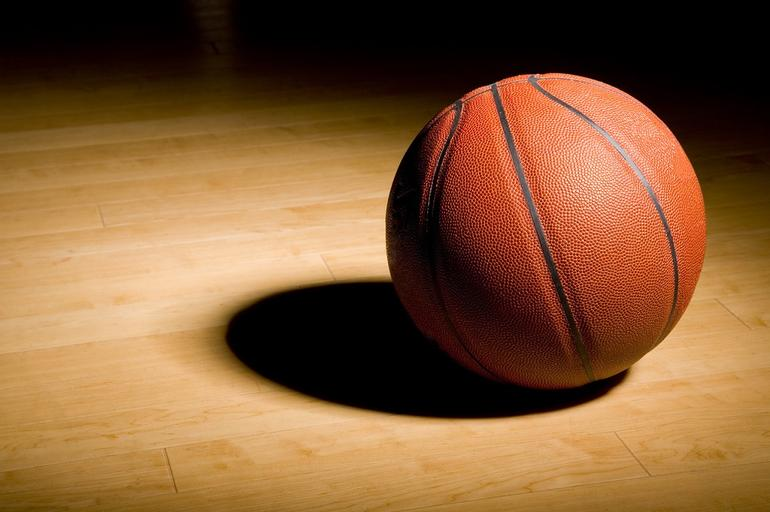

In [478]:
from IPython.display import Image
Image(filename='C:/Users/Raviraj/Pictures/basketball.jpg')

In [477]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import parallel_coordinates


In [3]:
%matplotlib inline
matplotlib.style.use('ggplot')


# Introduction

Dans cette étude notre but est d'appliquer des techniques de data science dans le monde du sport. En effet, bien que cette branche de la data ne soit pas la plus développé, les applications sont multiples et surtout les données sont abondantes. C'est donc pour cela que l'on a décidé de focaliser notre étude sur la prédiction des All NBA dans la league de BasketBall Americain. Ces équipes regroupent l'élite de la league et sont donc un critère de performance important. Aussi, on cherchera à identifier les critères les plus importants pour cette sélection.

En effet, derrière le terme All NBA se cache un critère de performance, où chaque joueur sélectionné dans ces promotions est une réelle référence. Ainsi, la prédiction All NBA permet de manière implicite de savoir si la performance est l'unique moteur à prendre en compte ou s'il existe d'autres variables comme la popularité qui viendraient affecter la sélection.

Il s'agit d'un problème de classification.


## 1.Data cleaning et preparation pour l'analyse des données

### &emsp;1.1 Import des datas et des packages

Pour obtenir les données nous avons eu recours à un site connu pour référencer de nombreuses statistiques que ce soit en terme de statistiques collectives, individuelles ou des datas plus détaillées. Il s'agit du site https://www.basketball-reference.com. Nous sommes particulièrement intéressés par les statistiques des joueurs sur la saison. Pour cela le site dispose d'une section recensant les statistiques de l'ensemble des joueurs de la ligue sous le lien https://www.basketball-reference.com/leagues. On peut ainsi scrapper le site puisque nous pouvons itérer les pages à l'aide d'une boucle le lien complet étant par exemple pour la saison actuelle https://www.basketball-reference.com/leagues/NBA_2019_totals.html. Nous allons requêter les statistiques totales par match ainsi que les statistiques avancés disponibles sous une autre page similaire. 
Nous allons donc ici nous ateler à la récupération des données via des méthodes de web scraping pour cela, nous aurons besoin des librairies BeautifulSoup et requests pour récupérer les informations HTML. Grâce à la fonction inspecter la page nous pouvons également repérer les balises nécessaires à la récupération des données.

In [4]:
from bs4 import BeautifulSoup
import requests
import sys

La première étape consiste à donner les liens qui permettent de requêter les données. On donne un chemin template que l'on modifiera ensuite notamment à travers des boucles pour pouvoir prendre les données de chaque année.

In [5]:
adv_url_template = "https://www.basketball-reference.com/leagues/NBA_{year}\
_advanced.html" #advanced data url
tot_url_template = "https://www.basketball-reference.com/leagues/NBA_{year}\
_totals.html" #total stat data url

In [6]:
#listes pour récupérer les noms de colonnes et les données des tables
column_headers = []
player_data = []
#crée un dataframe vide pour stocker les données. 
df = pd.DataFrame()

df_adv = pd.DataFrame()
df_tot = pd.DataFrame()
df_list = [df_adv, df_tot]



On définit trois fonctions qui vont être utile pour l'extraction des données. La fonction get_column_headers a pour but de trouver les noms des colonnes dans un HTML en prenant en entrée un objet soup généré grâce à la librairie BeautifulSoup. 
La fonction get_player_data permet elle de parcourir la table et d'extraire les informations joueur par joueur et enfin les fonctions get_season et gen_cleaning permettent respectivement de créer une colonne avec la saison pour laquelle on récupère les données et de nettoyer les données qu'on obtient.

In [7]:
def get_column_headers(soup):
    headers = []
    for th in soup.find('tr').findAll('th'): #cherche les headers dans le HTML
        headers.append(th.getText())
    return headers    

def get_player_data(soup):
    temp_player_data = []
    
    data_rows = soup.findAll('tr')[1:] # on passe la première ligne
    for i in range(len(data_rows)): # on parcourt les lignes
        player_row = [] # liste pour contenir les infos de chaque joueur
        for td in data_rows[i].findAll('td'):
            player_row.append(td.getText()) # prend les infos de la ligne sur le joueur
        temp_player_data.append(player_row) # insère dans la liste
    return temp_player_data

def get_season(input_year): #fonction pour avoir la saison
    first_yr = input_year - 1
    season = str(first_yr) + "-" + str(input_year)[2:]
    return season

def gen_cleaning(df):
    # Convertit en numeric
    df = df.apply(pd.to_numeric, errors = 'ignore')
    
    # Enleve les colonne vides
    df.dropna(axis = 1, how = "all", inplace = True)
    return df


La fonction scrape_page permet de requêter les données d'une page en prenant en argument une url en faisant appel aux fonctions précédemment définies

In [10]:
def scrape_page(url):
    r = requests.get(url) # requete l'url
    soup = BeautifulSoup(r.text, 'html.parser') # Crée un objet Beautiful Soup
    
    # Récupère les headers
    column_headers = get_column_headers(soup)
    
    # Récupère les données
    player_data = get_player_data(soup)

    df = pd.DataFrame(player_data, columns = column_headers[1:])
    
    return df

La fonction scrape_pages récupère des données entre deux dates définies par l'utilisateur.

In [11]:
def scrape_pages(url_template, start_year, end_year, output_df):
    count = 0 
    for year in range(start_year, (end_year+1)):
        url = url_template.format(year = year) # Requete l'url en changeant l'année
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html5lib') # Crée un objet Beautiful Soup
        
        # Récupère les headers
        if count == 0: 
            columns = get_column_headers(soup)
            count += 1
            
        # Récupère les données joueurs
        player_data = get_player_data(soup)
        
        #enlève les duplicatas et gardent la ligne agrégé Tot pour les joueurs ayant changé de saison
        year_df = pd.DataFrame(player_data, columns = columns[1:])
        year_df.drop_duplicates(['Player'], keep = 'first', inplace = True)
        
        #Insère dans un dataframe puis nettois
        year_df.insert(0, 'Season',get_season(year))
        output_df = output_df.append(year_df, ignore_index = True)
        

    output_df = gen_cleaning(output_df)
        
    return output_df


In [12]:
#Requête les données entre 1980 et 2019
start_year=1980
end_year=2019
df_adv = scrape_pages(adv_url_template, start_year, end_year, df_adv)
df_tot = scrape_pages(tot_url_template, start_year, end_year, df_tot)

In [13]:
#df_tot=df_tot.drop(['MP'],axis=1)
df_stats=pd.merge(df_adv,df_tot,how='left',on=['Season', 'Player', 'Pos', 'Age', 'Tm', 'G'])
df_stats['Year']=df_stats['Season'].apply(lambda x: int(x[0:4]))
df_stats['Year']=df_stats['Year'].apply(lambda x: x+1)
df_stats.to_csv('Nba_data.csv') #enregistre le dataframe au format csv

In [8]:
filename1="All.NBA.1984-2018.csv"
filename2="Nba_data.csv"
df_allnba=pd.read_csv(filename1, header=1) #header a partir de la ligne 1
df_stats=pd.read_csv(filename2, index_col=0) #colonne 1 du csv comme index

### &emsp;1.2 Visualisation des datas

Nous pouvons dans un premier temps regarder si les imports ont bien fonctionné en affichant les dataframes grâce à la fonction head() qui permet de visualiser les 5 premières lignes d'un dataframe.

In [9]:
print(df_allnba.shape)
df_allnba.head()

(475, 33)


,Rk,Player,Season,Age,Tm,Lg,WS,G,GS,MP,...,BLK,TOV,PF,PTS,FG%,2P%,3P%,eFG%,FT%,TS%
0,1,Michael Jordan,1987-88,24,CHI,NBA,21.2,82,82,3311,...,131,252,270,2868,0.535,0.546,0.132,0.537,0.841,0.603
1,2,Michael Jordan,1995-96,32,CHI,NBA,20.4,82,82,3090,...,42,197,195,2491,0.495,0.506,0.427,0.525,0.834,0.582
2,3,LeBron James,2008-09,24,CLE,NBA,20.3,81,81,3054,...,93,241,139,2304,0.489,0.535,0.344,0.530,0.780,0.591
3,4,Michael Jordan,1990-91,27,CHI,NBA,20.3,82,82,3034,...,83,202,229,2580,0.539,0.551,0.312,0.547,0.851,0.605
4,5,David Robinson,1993-94,28,SAS,NBA,20.0,80,80,3241,...,265,253,228,2383,0.507,0.510,0.345,0.510,0.749,0.577


In [10]:
print(df_stats.shape)
df_stats.head()

(16593, 52)


,Season,Player,Pos,Age,Tm,G,MP_x,PER,TS%,3PAr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1979-80,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,3143.0,25.3,0.639,0.001,...,190.0,696.0,886.0,371.0,81.0,280.0,297.0,216.0,2034.0,1980
1,1979-80,Tom Abernethy,PF,25.0,GSW,67.0,1222.0,11.0,0.511,0.003,...,62.0,129.0,191.0,87.0,35.0,12.0,39.0,118.0,362.0,1980
2,1979-80,Alvan Adams,C,25.0,PHO,75.0,2168.0,19.2,0.571,0.002,...,158.0,451.0,609.0,322.0,108.0,55.0,218.0,237.0,1118.0,1980
3,1979-80,Tiny Archibald*,PG,31.0,BOS,80.0,2864.0,15.3,0.574,0.023,...,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,1980
4,1979-80,Dennis Awtrey,C,31.0,CHI,26.0,560.0,7.4,0.524,0.000,...,29.0,86.0,115.0,40.0,12.0,15.0,27.0,66.0,86.0,1980


Dans cette étude, nous disposons de deux dataframes : df_allnba et df_stats. Le premier contient l'ensemble des joueurs ayant été sélectionné dans une all nba team au cours du temps. Notre objectif sera de prédire la sélection en all_nba ou pas. Nous avons choisi les all NBA et non pas les MVP car cela nous donne une profondeur de data un peu plus importante (1 seul MVP par saison vs 5 All_NBA par an).
La prédiction se base sur les statistiques des joueurs chaque saison d'où le dataframe df_stats. Cela implique comme on peut le voir grâce aux dimensions que df_stats est beaucoup plus volumineux que df_allnba. Nous allons progressivement merger ces deux dataframe en un.

In [11]:
df_stats.describe()

,Age,G,MP_x,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
count,16553.000000,16553.000000,16553.000000,16550.000000,16506.000000,16498.000000,16498.000000,16550.000000,16550.000000,16550.000000,...,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16553.000000,16593.000000
mean,26.736181,54.362472,1285.673654,12.791517,0.510095,0.168208,0.317194,6.145511,13.927595,10.037819,...,66.227753,160.672929,226.900683,122.786504,42.924606,26.978735,79.976741,118.889869,542.170785,2001.190924
std,4.067421,25.261340,924.794203,6.025797,0.088335,0.193792,0.215262,4.876192,6.488911,4.962780,...,68.017024,146.150591,207.756764,142.872134,38.721262,38.085415,67.904422,80.333596,491.550548,11.262299
min,18.000000,1.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1980.000000
25%,24.000000,35.000000,429.000000,10.000000,0.479000,0.006000,0.200000,2.500000,9.100000,6.100000,...,16.000000,45.000000,64.000000,22.000000,12.000000,4.000000,23.000000,48.000000,133.000000,1992.000000
50%,26.000000,62.000000,1205.000000,12.900000,0.520000,0.075000,0.286000,5.300000,12.900000,9.300000,...,43.000000,126.000000,174.000000,74.000000,34.000000,13.000000,64.000000,116.000000,415.000000,2002.000000
75%,29.000000,77.000000,2041.000000,15.800000,0.555000,0.304000,0.392000,9.000000,18.200000,13.500000,...,97.000000,231.000000,326.000000,171.000000,64.000000,33.000000,120.000000,180.000000,828.000000,2011.000000
max,44.000000,85.000000,3533.000000,133.800000,1.500000,1.000000,6.000000,100.000000,100.000000,86.400000,...,573.000000,1007.000000,1530.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,3041.000000,2019.000000


La méthode describe() est utile pour avoir rapidement une idée de la distribution des données grâce aux statistiques descriptives telle que le min/max, moyenne, écart-type etc...

In [12]:
df_allnba.dtypes #Vérifie si les données sont dans le bon type

Rk          int64
Player     object
Season     object
Age         int64
Tm         object
Lg         object
WS        float64
G           int64
GS          int64
MP          int64
FG          int64
FGA         int64
2P          int64
2PA         int64
3P          int64
3PA         int64
FT          int64
FTA         int64
ORB         int64
DRB         int64
TRB         int64
AST         int64
STL         int64
BLK         int64
TOV         int64
PF          int64
PTS         int64
FG%       float64
2P%       float64
3P%       float64
eFG%      float64
FT%       float64
TS%       float64
dtype: object

In [428]:
df_stats.dtypes

Season     object
Player     object
Pos        object
Age       float64
Tm         object
G         float64
MP_x      float64
PER       float64
TS%       float64
3PAr      float64
FTr       float64
ORB%      float64
DRB%      float64
TRB%      float64
AST%      float64
STL%      float64
BLK%      float64
TOV%      float64
USG%      float64
OWS       float64
DWS       float64
WS        float64
WS/48     float64
OBPM      float64
DBPM      float64
BPM       float64
VORP      float64
GS        float64
MP_y      float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
AST       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
Year        int64
dtype: object

Il peut aussi être utile pour bien connaitre nos données de savoir quels sont les colonnes à notre disposition. Au lieu d'utiliser un .columns nous choisissons d'utiliser dtypes pour avoir en même temps les types des données contenues dans les colonnes. Ainsi, on peut voir que nous avons principalement des données quantitatives (int64 et float64) et peu de données qualitatives bien que l'on ait quelques unes comme le nom de l'équipe, nom du joueur, son poste, etc... On peut ainsi voir les différents features qui sont à notre disposition, certaines n'étant pas très explicites nous allons fournir une description de ces features.

__Glossaire des variables__ : définition des variables également disponibles sur basketball_reference

*__Season__: Saison pour laquelle les données ont été mesurées

*__Player__: Nom du joueur

*__Pos__: Position occupée par le joueur

*__Age__: Age du joueur

*__Tm__: Equipe

*__G__: Nombre de matchs joués

*__MP_x__: Nombre de minutes jouées

*__PER__:Player Efficiency Rating : mesure de la production d'un joueur par minute normalisée de sorte à ce que la moyenne de la ligue soit de 15.

*__TS%__: True Shooting Percentage regroupe les 2P, 3P, Free Throws

*__3Par__:% d'essais au 3 points

*__Ftr__: % au lancer francs

*__ORB%, DRB%, TRB%__: Offensive Rebound, Defensive Rebound, Total Rebound %

*__AST, STL, BLK, TOV, USG__: Assist : passe décisive, Steal: possession qui se finit par une récupération de balle, Block : possession qui se finit par un contre, Turnover: estimation du nombre de perte de balles par 100 possessions, Usage: estimation du nombre de possession utilisé par un joueur quand il est sur le parquet

*__OWS, DWS, WS, WS/48__: estimation du nombre de victoire du à la contribution offensive d'un joueur, estimation du nombre de victoire du à la contribution defensive d'un joueur, estimation du nombre de victoire où un joueur à contribuer, estimation du nombre de victoire où un joueur à contribuer par 48 minutes

*__OPBM, DBPM, BPM__: box score (offensif/defensif) des points par 100 min où un joueur a contribué plus que le "joueur moyen" de la ligue

*__3P/2P 3PA/2PA 3P%/2P%__: Nombre de 3Points/2 Points; 3/2 points tentés; % 3 points/2points 

*__FT/FTA/FT%__ : Nombre de Free Throws, Free Thows tentés, % au Free Throws

*__PF__: Fautes individuelles



### &emsp;1.3 Data cleaning

Avant d'élaborer de quelconques modèles de machine learning nous devons nous assurer de la pertinence des datasets et d'y apporter des retouches si besoin.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           1.3.1 Reduction de la taille des données

Nous remarquons que le dataset all_nba ne contient pas de colonnes à proprement dite d'année. Nous disposons cependant d'une colonne 'Season' mais qui s'écrit avec deux années, par exemple la saison 2006-2007. Cela n'est pas très pratique si jamais nous aurions envie de filtrer les dataframes. Nous allons donc rajouter une colonne Année comme suit :

In [444]:
df_allnba['Year']=df_allnba['Season'].apply(lambda x: int(x[0:4]))# crée une nouvelle colonne d'année
df_allnba['Year']=df_allnba['Year'].apply(lambda x: x+1) #ajoute un pour avoir l'année de la saison 2017-2018=>year:2018

La date de référence que l'on peut identifier en NBA est l'arrivée dans la ligue de Michael Jordan. Avant son arrivée le basket se jouait différemment et les statistiques étaient mesurées de manière beaucoup moins fiable qu'après son arrivée. Nous allons donc enlever les données dont la date est inférieur à 1988 pour avoir des données fiables mais également pertinente pour la prédiction ultérieure.

Aussi, nous allons tout de même procéder à un check pour détecter les valeurs manquante dans le dataset et voir si cela est normal ou si l'on peut apporter des retraitements.

In [445]:
df_stats=df_stats[df_stats['Year']>1988]
df_allnba=df_allnba[df_allnba['Year']>1988]
df_stats.isnull().sum() #Pour détecter le nombre de valeurs manquantes dans les colonnes

Season       0
Player       0
Pos          0
Age          0
Tm           0
G            0
MP_x         0
PER          0
TS%         44
3PAr        50
FTr         50
ORB%         0
DRB%         0
TRB%         0
AST%         0
STL%         0
BLK%         0
TOV%        36
USG%         0
OWS          0
DWS          0
WS           0
WS/48        0
OBPM         0
DBPM         0
BPM          0
VORP         0
GS           0
MP_y         0
FG           0
FGA          0
FG%         50
3P           0
3PA          0
3P%       2113
2P           0
2PA          0
2P%         80
eFG%        50
FT           0
FTA          0
FT%        441
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
Year         0
dtype: int64

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           1.3.2 Données manquantes

Un des indicateurs que regardent principalement les analyste est le PER ( Player Efficiency Rating) qui est une note qui résume l'efficacité d'un joueur en s'appuyant sur diverses statistiques (shooting percentage, assist, etc...). C'est une statistique importante dans notre analyse également cependant nous voyons 5 valeurs qui manquent. Nous pouvons investiguer dessus :

In [446]:
#recherche pourquoi certains PER sont nuls
print(df_stats[df_stats['PER'].isnull()])
#1-2 matchs et peu de minutes pour que la NBA calcul un PER. 
df_stats=df_stats.dropna(subset=['PER']) #on enlève ces joueurs 

Empty DataFrame
Columns: [Season, Player, Pos, Age, Tm, G, MP_x, PER, TS%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP, GS, MP_y, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, Year]
Index: []

[0 rows x 52 columns]


On remarque que certaines valeurs sont manquantes dans une des colonnes les plus importantes pour la prédiction. En investigant sur ces données manquantes on se rend compte que les joueurs qui n'ont pas de PER n'ont pas joué énormément (matchs et minutes), le PER n'a donc pas été calculé par la NBA pour ces joueurs par faute de temps de jeu. Notre objectif étant de prédire les all NBA teams nous pouvons enlever ces joueurs du dataset car ils n'apportent pas d'information du fait de leur faible temps de jeu.

Nous avons remarqué un nombre important de valeurs nulle dans la colonne 3 point. Afin de savoir si ces données sont manquantes ou sont cohérentes (joueurs ayant réellement des pourcentages au 3 point nuls), nous regardons la répartition par poste des valeurs manquantes. Il apparait que 80% des valeurs manquantes proviennent de joueurs jouant Center ou Power Forward. Ces deux types de joueurs n'ont en général pas de bon pourcentage voire ne s'y essaye pas ! Les valeurs manquantes sont donc ici cohérentes.

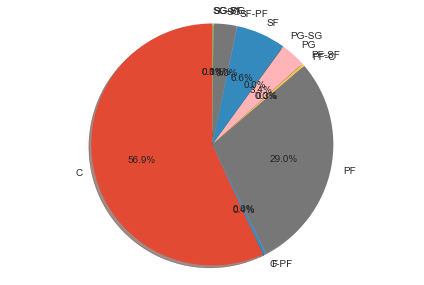

In [447]:
df3=df_stats[df_stats['3P%'].isnull()].groupby('Pos').size().to_frame('Taille') #Regroupe les données manquantes par position
fig1, graph=plt.subplots()
graph.pie(x=df3['Taille'],labels=df3.index,autopct='%1.1f%%',startangle=90,shadow=True)# graphique en camembert pour voir la répartition par position des données manquantes
graph.axis('equal')
plt.tight_layout()

On peut également s'assurer que les données sont bien correctes en regardant le nombre d'équipe par saison. En faisant cela on se rend compte qu'il y a une équipe en plus à chaque fois mais cela est bien normal comme nous l'avions vu lors du scrape des données

In [448]:
print(df_stats[df_stats.Year==2017]['Tm'].nunique()) #31 teams en  2017. 30 teams officielles
print(df_stats.groupby('Year').agg(['nunique'])) #2004 : 30 teams mais 29 officielles, il y a une équipe en plus à chaque fois
df_stats[df_stats.Year==2017]['Tm'].unique() #comme nous l'avions vu lors du scrape, il y a une team TOT pour les joueurs qui change
#d'équipe en cours de saison et qui agrège leurs statistiques.

31
      Season  Player     Pos     Age      Tm       G    MP_x     PER     TS%  \
     nunique nunique nunique nunique nunique nunique nunique nunique nunique   
Year                                                                           
1989       1     352       7      17      26      77     336     147     175   
1990       1     380       7      18      28      75     354     170     198   
1991       1     386       7      17      28      77     362     157     186   
1992       1     386       8      18      28      78     356     157     183   
1993       1     390       9      19      28      78     366     150     178   
1994       1     403       5      19      28      78     371     159     192   
1995       1     406       7      20      28      80     373     168     191   
1996       1     428       7      22      30      79     394     178     201   
1997       1     441       8      24      30      82     413     177     199   
1998       1     439       6      23 

array(['OKC', 'TOT', 'SAC', 'NOP', 'MIN', 'SAS', 'IND', 'MEM', 'POR',
       'CLE', 'LAC', 'HOU', 'MIL', 'NYK', 'DEN', 'ORL', 'MIA', 'PHO',
       'DAL', 'CHO', 'PHI', 'DET', 'ATL', 'WAS', 'BRK', 'LAL', 'UTA',
       'BOS', 'CHI', 'TOR', 'GSW'], dtype=object)

Avec notre dataframe actuel nous avons beaucoup de données : à peu près 50 colonnes. Cela est beaucoup sachant que nous n'allons pas les utiliser toutes. Nous avons en tête certaines variables incontournables comme le nombre de points, d'assist, etc...
On peut essayer de dessiner une heatmap de correlation pour nous aider à faire le tri dans nos données.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           1.3.2 Réduction de la taille du dataframe 

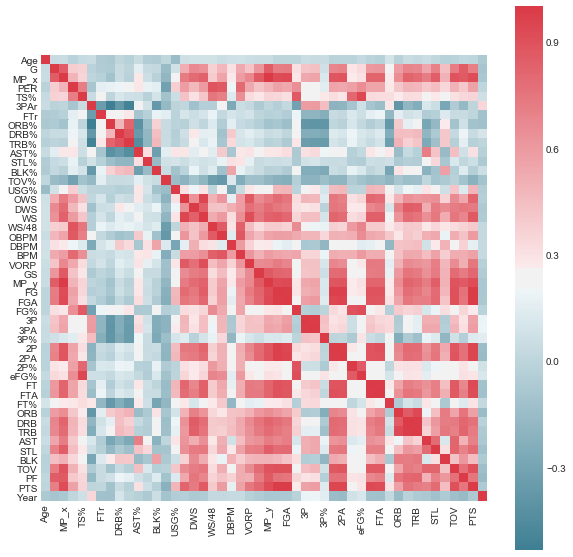

In [449]:
import seaborn as sns
#Drawing a correlation plot
f, ax = plt.subplots(figsize=(10, 10))
corr = df_stats.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

La heatmap de correlation permet de visualiser les corrélation entre les variables. Avec 52 variables, la lisibilité est moindre et certaines variables sont redondantes comme le montre les corrélations élevés (certaines variables sont juste la transcription en % d'autres variables contenues dans le dataframe). 

Nous allons donc réduire le nombres de variables en sélectionnant celles qui nous semble les plus pertinentes.

In [450]:
frames=df_stats['Player'].to_frame() #dataframe intermédiaire pour construire le suivant
nb_colonnes=len(df_stats.columns)
Games=df_stats.G
#crée un nouveau dataframe avec les variables vouluesgrâce à la méthode assign
df_stats.assign(Nom=df_stats.Player, Position=df_stats.Pos, age=df_stats.Age,ThreePoints=df_stats.PTS/df_stats.G,PF2=df_stats.PF/df_stats.G)
#crée un nouveau dataframe en normalisant par le nombre de matchs joués
df_pergame=frames.assign(Position=df_stats.Pos, age=df_stats.Age, year=df_stats.Year, Team=df_stats.Tm, Games=df_stats.G, Games_started=df_stats.GS, Minutes=df_stats.MP_x/Games, Efficiency_Rating=df_stats.PER, BoxPlusMinus=df_stats.BPM, TwoPoints=df_stats['2P']/Games, ThreePoints=df_stats['3P']/Games, FreeThrows=df_stats.FT/Games,Points=df_stats.PTS/Games, Assist=df_stats.AST/Games,OffensiveRebound=df_stats.ORB/Games,DefensiveRebound=df_stats.DRB/Games, Steals=df_stats.STL/Games, Blocks=df_stats.BLK/Games, Turnover=df_stats.TOV/Games, Fouls=df_stats.PF/Games)
df_pergame=df_pergame.reset_index()#remet l'indexation à 0
df_pergame=df_pergame.drop(['index'], axis=1)#l'ancien index se décale en créant une colonne, nous la supprimons directement

Les variables ainsi choisies sont celles qui reviennent le plus souvent dans les analyses et sont donc pertinentes pour analyser les données. Cela amène également plus de lisibilité.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           1.3.2 A la recherche des outliers

Nous pouvons chercher des outliers dans les données. Nous allons les détecter de deux manières de façon rapide.
Tout d'abord en calculant des z-scores et en regardant quels z-scores dépassent un certain seuil. Puis avec le critère IQR qui revient à considérer comme outlier toutes les données supérieures au quantile à 25% et à 75%. 
Aucune méthode n'est meilleure que l'autre mais elles permettent d'identifier rapidement les outliers ie. les données apportant une grande variance. 

In [451]:
from scipy import stats

In [452]:
#compute quickly a z-score to look after outliers
z = np.abs(stats.zscore(df_pergame.drop(['Position','Player', 'Team'],axis=1)))

In [453]:
#affiche les entrées pour lesquelles le z-score est supérieur au seil
df_pergame.iloc[np.where(z>3)] #seuil arbitraire

,Player,Assist,Games_started,BoxPlusMinus,FreeThrows,OffensiveRebound,ThreePoints,OffensiveRebound,Minutes,BoxPlusMinus,...,Points,Assist,DefensiveRebound,Games_started,FreeThrows,Points,OffensiveRebound,Games,Games_started,DefensiveRebound
0,Kareem Abdul-Jabbar*,1.000000,74.0,-2.3,1.648649,1.391892,0.000000,1.391892,22.905405,-2.3,...,10.108108,1.000000,3.121622,74.0,1.648649,10.108108,1.391892,74.0,74.0,3.121622
2,Michael Adams,6.363636,77.0,3.2,4.181818,0.922078,2.155844,0.922078,36.194805,3.2,...,18.493506,6.363636,2.753247,77.0,4.181818,18.493506,0.922078,77.0,77.0,2.753247
15,Greg Ballard,0.000000,0.0,-21.9,2.000000,1.000000,0.000000,1.000000,7.500000,-21.9,...,3.000000,0.000000,2.500000,0.0,2.000000,3.000000,1.000000,2.0,0.0,2.500000
17,Charles Barkley*,4.113924,79.0,9.8,7.620253,5.101266,0.443038,5.101266,39.088608,9.8,...,25.784810,4.113924,7.379747,79.0,7.620253,25.784810,5.101266,79.0,79.0,7.379747
17,Charles Barkley*,4.113924,79.0,9.8,7.620253,5.101266,0.443038,5.101266,39.088608,9.8,...,25.784810,4.113924,7.379747,79.0,7.620253,25.784810,5.101266,79.0,79.0,7.379747
19,Benoit Benjamin,1.987342,62.0,0.4,4.012658,2.075949,0.000000,2.075949,32.721519,0.4,...,16.443038,1.987342,6.734177,62.0,4.012658,16.443038,2.075949,79.0,62.0,6.734177
26,Muggsy Bogues,7.848101,21.0,-3.1,0.835443,0.670886,0.012658,0.670886,22.215190,-3.1,...,5.354430,7.848101,1.417722,21.0,0.835443,5.354430,0.670886,79.0,21.0,1.417722
27,Manute Bol,0.337500,4.0,-1.0,0.500000,1.450000,0.250000,1.450000,22.112500,-1.0,...,3.925000,0.337500,4.325000,4.0,0.500000,3.925000,1.450000,80.0,4.0,4.325000
46,Tom Chambers,2.851852,81.0,1.2,6.283951,1.765432,0.345679,1.765432,37.061728,1.2,...,25.740741,2.851852,6.679012,81.0,6.283951,25.740741,1.765432,81.0,81.0,6.679012
46,Tom Chambers,2.851852,81.0,1.2,6.283951,1.765432,0.345679,1.765432,37.061728,1.2,...,25.740741,2.851852,6.679012,81.0,6.283951,25.740741,1.765432,81.0,81.0,6.679012


In [454]:
#check for ouliers : method 2
Q1=df_pergame.quantile(0.25) #calcul 25% quantile
Q3=df_pergame.quantile(0.75) #calul 75% quantile
IQR=Q3-Q1 #calcul IQR

Après avoir calculé l'IQR on peut regarder les données sortant de l'intervalle. Ce sont des données dont les valeurs apportent de la variance par rapport au reste des données. Ainsi, on peut se rendre compte que souvent cela vient des joueurs jouant peu de matchs, on affiche les données pour s'en rendre compte et on voit des PER parfois très anormaux.

In [455]:
df=(df_pergame.drop(['Position','Player', 'Team'],axis=1)< (Q1 - 1.5 * IQR)) |(df_pergame.drop(['Position','Player', 'Team'],axis=1) > (Q3 + 1.5 * IQR))

In [456]:
df_pergame[df.values]
df_pergame.iloc[np.where(df_pergame['Games'].values<30)] #Grande variance dans les PER ligne 47,60=>-43;-20.3

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,ThreePoints,FreeThrows,Points,Assist,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls
7,Randy Allen,SG,24.0,1989,SAC,7.0,0.0,6.142857,6.9,-12.4,...,0.000000,0.142857,2.428571,0.000000,0.428571,0.571429,0.142857,0.142857,0.285714,1.000000
15,Greg Ballard,SF,34.0,1989,SEA,2.0,0.0,7.500000,7.1,-21.9,...,0.000000,2.000000,3.000000,0.000000,1.000000,2.500000,0.000000,0.000000,0.000000,1.500000
16,Ken Bannister,PF,28.0,1989,LAC,9.0,2.0,14.444444,17.9,-3.7,...,0.000000,3.333333,8.222222,0.333333,0.666667,3.000000,0.777778,0.222222,0.888889,1.888889
22,Larry Bird*,SF,32.0,1989,BOS,6.0,6.0,31.500000,19.8,0.5,...,0.000000,3.000000,19.333333,4.833333,0.166667,6.000000,1.000000,0.833333,1.833333,3.000000
23,Otis Birdsong,SG,33.0,1989,BOS,13.0,0.0,8.307692,7.0,-6.3,...,0.076923,0.000000,2.846154,0.692308,0.307692,0.692308,0.230769,0.076923,0.923077,0.769231
28,Anthony Bowie,SG,25.0,1989,SAS,18.0,5.0,24.333333,10.6,-2.5,...,0.055556,0.555556,8.611111,1.611111,1.388889,1.722222,1.000000,0.222222,1.222222,2.388889
29,Sam Bowie,C,27.0,1989,POR,20.0,0.0,20.600000,13.7,-1.2,...,0.250000,1.400000,8.550000,1.800000,1.800000,3.500000,0.350000,1.650000,1.650000,2.150000
45,Ron Cavenall,C,29.0,1989,NJN,5.0,0.0,3.200000,7.4,-10.4,...,0.000000,0.400000,1.200000,0.000000,0.000000,0.400000,0.000000,0.400000,0.400000,0.400000
47,Mike Champion,SF,24.0,1989,SEA,2.0,0.0,2.000000,-43.7,-40.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
60,Winston Crite,SF,23.0,1989,PHO,2.0,0.0,3.000000,-20.3,-27.1,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000


(array([ 545.,  226.,   97.,   80.,   67.,   33.,   25.,   42.,   46.,
          57.,   48.,   47.,   78.,  129.,  170.,  185.,  118.,  159.,
         194.,  197.,  296.,  444.,  476.,  673., 1239.,  889.]),
 array([ 1.        ,  4.23076923,  7.46153846, 10.69230769, 13.92307692,
        17.15384615, 20.38461538, 23.61538462, 26.84615385, 30.07692308,
        33.30769231, 36.53846154, 39.76923077, 43.        , 46.23076923,
        49.46153846, 52.69230769, 55.92307692, 59.15384615, 62.38461538,
        65.61538462, 68.84615385, 72.07692308, 75.30769231, 78.53846154,
        81.76923077, 85.        ]),
 <a list of 26 Patch objects>)

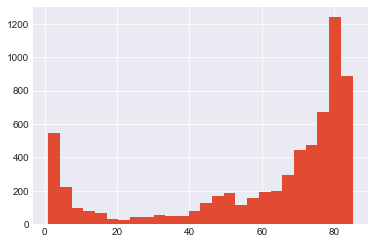

In [457]:
plt.hist(df_pergame[df.values]['Games'],bins='auto') #see the repartition of values that don't pass the IQR test

Beaucoup de valeur viennent du fait que peu de match ont été joués, nous pouvons donc enlever les joueurs n'ayant pas joué suffisamment de matchs car cela peut nuire à la qualité des données notamment en rajoutant de la variance dans des statistiques importantes +/-, PER, etc... 

Cela vient du fait que la NBA propose des statistiques qui ne conviennent pas aux joueurs qui jouent peu du fait de peu d'observations. Ainsi, parfois elle s'abstient de calculer mais parfois elle calcule des statistiques pour des joueurs qui jouent tellement peu que cela biaise les données. Nous préférons donc enlever ces joueurs qui plus tard lors de la phase de prédiction pourrait se retrouver dans les échantillons d'apprentissage et biaiser le processus d'apprentissage.

In [458]:
print(df_pergame.shape)
df_pergame=df_pergame[df_pergame.Games>10]
df_pergame.reset_index()
print(df_pergame.shape)
#drop approximately 1500 observations

(13720, 21)
(12499, 21)


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           1.3.3. Passage de deux dataframes à un seul

A présent, nous allons combiner nos deux dataframes. En effet, le dataframe all NBA ne nous sert en réalité qu'à connaitre les joueurs All NBA et on pourrait très bien insérer une colonne de flag dans le dataframe stats pour n'avoir qu'un seul dataframe à utiliser. 

Le problème qui se pose ici est que l'on ne peut pas directement combiner les datasets avec une clé comme le nom puisque dans le df_pergame on dispose de plusieurs saisons et donc de joueurs qui se répète. Larry Bird pouvait être All NBA en 91 mais pas en 92 par exemple. De plus de nombreux joueurs ont le même nom. 

Pour flagger les joueurs All_NBA on a ainsi créer des clés artificielles ne pouvant être spécifique que au joueurs ALL NBA. Cela est fait en concaténant les équipes, l'année et le nom. Ainsi, on est sur de trouver le bon joueur en créant une clé de ce type dans le dataframe all_nba et la même clé dans df_pergame. On crée ainsi une jointure artificielle !

In [459]:
df_pergame = df_pergame.astype({"age": int, "year": int}) #change le type des données

In [460]:
df_pergame=df_pergame.assign(cle=df_pergame['Team']+df_pergame['year'].map(str)+df_pergame['Player'].map(str)) #concaténation et création de la clé dans le 1er dataframe
df_allnba=df_allnba.assign(cles=df_allnba['Tm']+df_allnba['Year'].map(str)+df_allnba['Player'].map(str))#idem
df_pergame.loc[df_pergame['cle'].isin(df_allnba.cles.values)]#regarde les valeurs dont les clés coincident

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,FreeThrows,Points,Assist,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle
46,Tom Chambers,PF,29,1989,PHO,81.0,81.0,37.061728,19.3,1.2,...,6.283951,25.740741,2.851852,1.765432,6.679012,1.074074,0.679012,2.851852,3.345679,PHO1989Tom Chambers
62,Terry Cummings,SF,27,1989,MIL,80.0,78.0,35.300000,19.7,1.7,...,4.525000,22.862500,2.475000,3.512500,4.612500,1.325000,0.900000,2.512500,3.312500,MIL1989Terry Cummings
89,Dale Ellis,SG,28,1989,SEA,82.0,82.0,38.902439,19.7,2.1,...,4.597561,27.475610,2.000000,1.902439,2.268293,1.317073,0.268293,2.658537,2.402439,SEA1989Dale Ellis
152,Kevin Johnson,PG,22,1989,PHO,81.0,81.0,39.246914,20.5,3.5,...,6.271605,20.370370,12.234568,0.567901,3.629630,1.666667,0.296296,3.975309,2.790123,PHO1989Kevin Johnson
245,Mark Price,PG,24,1989,CLE,75.0,74.0,36.373333,20.6,3.5,...,3.506667,18.853333,8.413333,0.640000,2.373333,1.533333,0.093333,2.826667,1.306667,CLE1989Mark Price
405,Tom Chambers,PF,30,1990,PHO,81.0,81.0,37.604938,20.9,1.8,...,6.876543,27.172840,2.345679,1.493827,5.555556,1.086420,0.580247,2.691358,3.209877,PHO1990Tom Chambers
511,Kevin Johnson,PG,23,1990,PHO,74.0,74.0,37.594595,22.8,3.7,...,6.770270,22.500000,11.432432,0.567568,3.081081,1.283784,0.189189,3.554054,1.932432,PHO1990Kevin Johnson
901,Kevin Johnson,PG,24,1991,PHO,77.0,76.0,36.000000,23.7,5.2,...,6.740260,22.207792,10.142857,0.701299,2.818182,2.116883,0.142857,3.493506,2.259740,PHO1991Kevin Johnson
1202,Brad Daugherty,C,26,1992,CLE,73.0,73.0,36.205479,23.0,5.0,...,5.671233,21.452055,3.589041,2.616438,7.794521,0.890411,1.068493,2.534247,2.602740,CLE1992Brad Daugherty
1265,Tim Hardaway,PG,25,1992,GSW,81.0,81.0,41.135802,19.1,2.6,...,3.679012,23.370370,9.962963,1.000000,2.827160,2.024691,0.160494,3.296296,2.567901,GSW1992Tim Hardaway


Une fois la jointure faite, il ne reste plus qu'à regarder si l'on a bien toutes les informations et qu'on a bien récupérer les données de tous les all nba dans notre df_pergame.

Malheureusement, on se rend compte que ce n'est pas le cas. On rappelle qu'une promotion all nba est composée de 15 joueurs, nous nous attendions donc a avoir 15 joueurs all nba par an.

In [461]:
df=df_pergame.loc[df_pergame['cle'].isin(df_allnba.cles.values)] 
df.groupby('year').agg('count')#regroupe les all nba par an et compte leur nombre

,Player,Position,age,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,TwoPoints,...,FreeThrows,Points,Assist,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle
year,,,,,,,,,,,,,,,,,,,,,
1989,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1990,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1991,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1992,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1993,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1994,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1995,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1996,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1997,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


On va donc investiguer pour voir s'il y a un problème avec les clés.

In [462]:
frames=df_allnba[df_allnba.Year==2000].cles.to_frame()
frames

,cles
10,LAL2000Shaquille O'Neal
59,UTA2000Karl Malone
99,SEA2000Gary Payton
136,SAS2000Tim Duncan
145,MIA2000Alonzo Mourning
164,SAS2000David Robinson
196,TOR2000Vince Carter
209,MIN2000Kevin Garnett
274,DET2000Grant Hill
278,SAC2000Chris Webber


En 2000, on voit que sur les 15 clés il n'y a rien de particulier à signaler. Les clés ont bien été générés comme attendus et on aurait du trouver une correspondance.

In [463]:
df=df_pergame[df_pergame.year==2000] #isole l'année 2000

In [464]:
print (df[df.cle.isin(frames.cles)]) #affiche les joueurs All NBA en 2000

               Player Position  age  year Team  Games  Games_started  \
4506      Kobe Bryant       SG   21  2000  LAL   66.0           62.0   
4520     Vince Carter       SF   23  2000  TOR   82.0           82.0   
4567       Tim Duncan       PF   23  2000  SAS   74.0           74.0   
4590    Kevin Garnett       PF   23  2000  MIN   81.0           81.0   
4656      Eddie Jones       SG   28  2000  CHH   72.0           72.0   
4696  Stephon Marbury       PG   22  2000  NJN   74.0           74.0   
4864     Chris Webber       PF   26  2000  SAC   75.0           75.0   

        Minutes  Efficiency_Rating  BoxPlusMinus           ...            \
4506  38.242424               21.7           5.3           ...             
4520  38.121951               23.4           4.6           ...             
4567  38.851351               24.8           6.1           ...             
4590  40.037037               23.6           6.1           ...             
4656  38.986111               19.9         

Ici on peut identifier les joueurs manquants par rapport aux clés précédemment. on voit que Gary Payton, pourtant un très grand joueur n'est pas présent.

In [465]:
df_stats.loc[df_stats['Player'] == 'Gary Payton']

,Season,Player,Pos,Age,Tm,G,MP_x,PER,TS%,3PAr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
15426,2016-17,Gary Payton,PG,24.0,MIL,6.0,99.0,4.5,0.413,0.409,...,0.0,12.0,12.0,13.0,3.0,4.0,10.0,9.0,20.0,2017
15958,2017-18,Gary Payton,PG,25.0,TOT,23.0,221.0,9.8,0.443,0.338,...,13.0,31.0,44.0,21.0,7.0,3.0,7.0,30.0,69.0,2018
16472,2018-19,Gary Payton,PG,26.0,WAS,1.0,1.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019


Trois entrées pour le joueur et de plus de 2017 à 2019 alors que le joueur est censé être retraité et all NBA en 2000... Peut être que le nom est mal orthographié dans la base.

In [466]:
liste=[]
for j in range(1, len(df_pergame)):
    if ('Gary Payton' in df_pergame.iloc[j-1]['Player']):
        liste.append(df_pergame.iloc[j-1]['Player'])
print(liste)


['Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton*', 'Gary Payton']


On peut voir qu'ils semblent y avoir des noms de joueurs écrits avec des étoiles à la suite ce qui fait planter les clés ! Nous aurions pu voir cette erreur plus tôt dans l'analyse mais nous pouvons le corriger assez simplement.

In [467]:
df_pergame=df_pergame.reset_index(drop=True)
for i in range(0,len(df_pergame)):
    if ('*' in df_pergame['Player'][i]):
        df_pergame.loc[i,'Player']=df_pergame['Player'][i][:-1]#enleve le dernier charactere si ce dernier est une étoile


In [468]:
df_pergame = df_pergame.astype({"age": int, "year": int})
#Refais la même procédure : génère des clés puis compte le nombre de All NBA
df_pergame=df_pergame.assign(cle=df_pergame['Team']+df_pergame['year'].map(str)+df_pergame['Player'].map(str))

df_allnba=df_allnba.assign(cles=df_allnba['Tm']+df_allnba['Year'].map(str)+df_allnba['Player'].map(str))

df_pergame.loc[df_pergame['cle'].isin(df_allnba.cles.values)]
df=df_pergame.loc[df_pergame['cle'].isin(df_allnba.cles.values)]
df.groupby('year').agg('count')

,Player,Position,age,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,TwoPoints,...,FreeThrows,Points,Assist,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle
year,,,,,,,,,,,,,,,,,,,,,
1989,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1990,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1991,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1992,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1993,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1994,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1995,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1996,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1997,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15


Cette fois, nous les avons bien tous récupérés ! Il ne reste plus qu'a encoder ce flag All NBA en mettant 1 à la ligne si le joueur est All NBA et 0 sinon.

In [469]:
df_pergame['isAllNBA']=df_pergame['year'] #remplit les valeurs avec les valeurs d'une autre colonne pour l'instant
for i in range(0,len(df_pergame)):
    if (df_pergame['cle'][i] in (df_allnba.cles.values)):
#        df_pergame['isAllNBA'][i]=0
         df_pergame.loc[i,'isAllNBA']=1 #met un 1 si le joueur est All NBA
    
    else:
        df_pergame.loc[i,'isAllNBA']=0 #0 sinon
#    print(df_pergame['cle'][i])
print(df_pergame['isAllNBA'].sum()) #pour checker si ça a bien fonctionné on a bien 435 All NBA, le compte est bon

435


Après ces retraitements, les données semblent prêtes pour analyse

# 2. Data exploration

### &emsp;2.1 Distributions

Cette partie va consister en l'étude des données principalement avec des outils de statistiques descriptives mais également de l'analyse graphique. En effet, il va s'agir de trouver des relations entre les variables pour nous aider dans la modélisation dans la partie 3. 

Sans recourir à des algorithmes complexes, il existe en effet de nombreuses façons de faire parler les données grâce à des méthodes simple. Dans un premier temps nous allons nous intéresser à la distribution des données. 

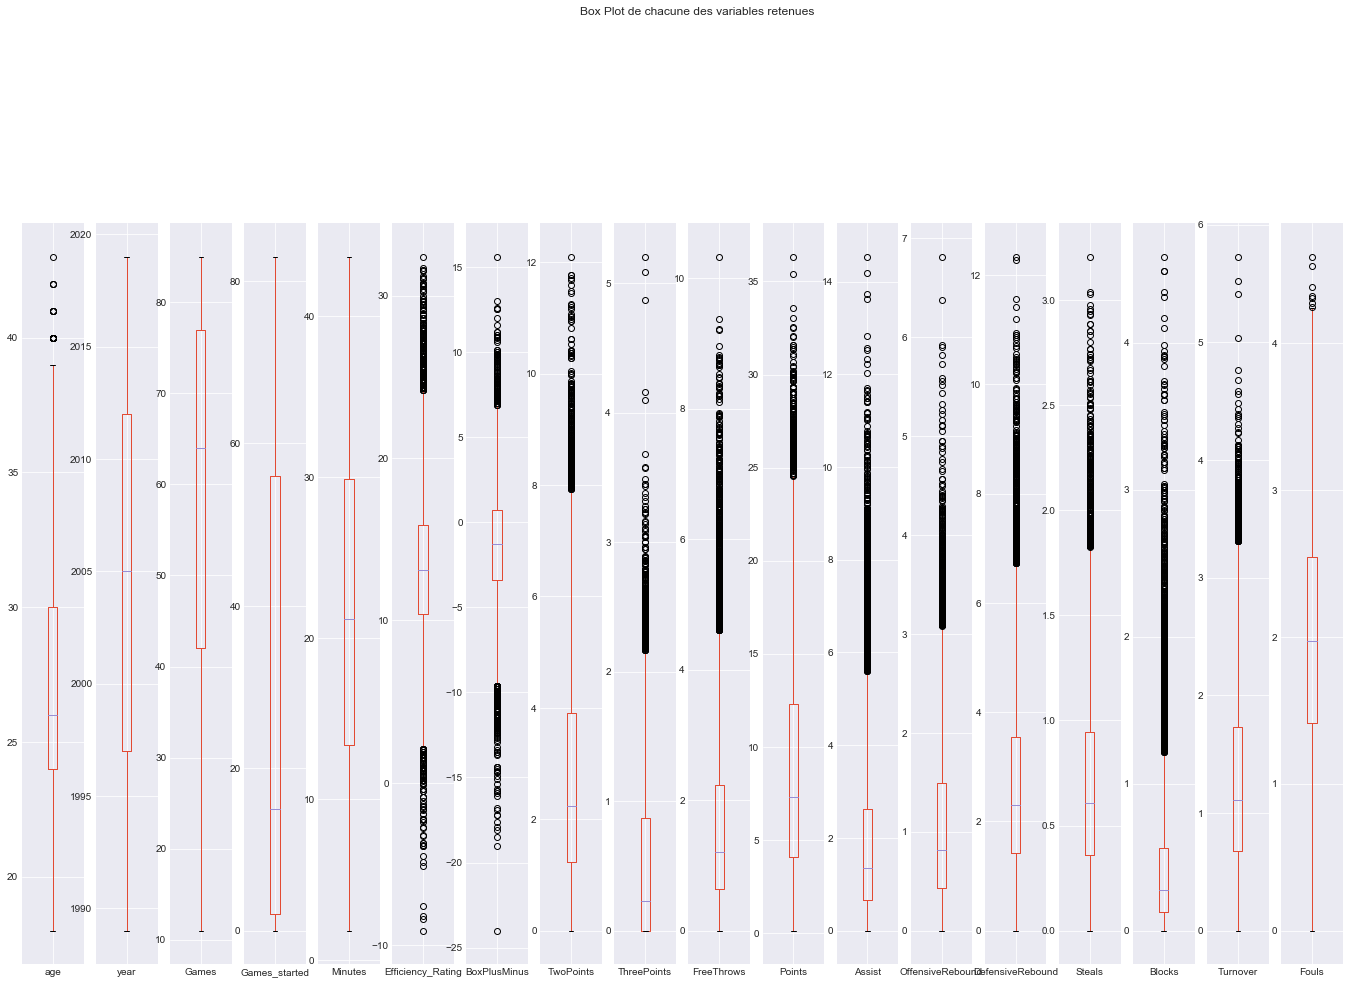

In [470]:
df_pergame.drop(['Player','Position', 'Team', 'cle', 'isAllNBA'], axis=1).plot(kind='box', subplots=True, layout=(2,19), sharex=False, sharey=False, figsize=(25,30), title='Box Plot de chacune des variables retenues')
plt.show()

On peut remarquer de la dispersion dans nos variables, les points représentent les outliers et on peur donc voir qu'il y a beaucoup d'outliers sur des variables comme les assist, les points etc... Cela montre que notre dataset comporte une multitude de joueurs avec chacun un style bien particulier.

Par exemple, pour les trois points on peut voir que le boxplot est moins applatie pour les Shooting Guards que pour les Power Forward et que moins d'outliers sont présents chez les shooting guards que sur les Power Forward. Cela signifie donc que les Shooting Guards ont une appétence plus forte pour les tirs à trois points

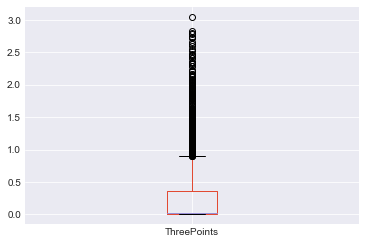

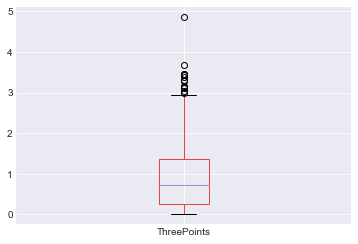

In [471]:
df_pergame[df_pergame.Position=='PF']['ThreePoints'].plot(kind='box') #regarde les 3 points pour les PF
plt.show()
df_pergame[df_pergame.Position=='SG']['ThreePoints'].plot(kind='box') #regarde les 3 points pour les SG
plt.show()

Une autre façon de regarder les distributions est de regarder les histogrammes ou les densités. Cela permet de se rendre compte de façon visuelle de la distribution des données et de leurs caractéristiques(variance, centré,etc...)

Certaines variables sont ainsi clairement centré comme le PER et le PlusMinus. D'autres ont une légère asymétrie comme les assist, blocks, points, etc...

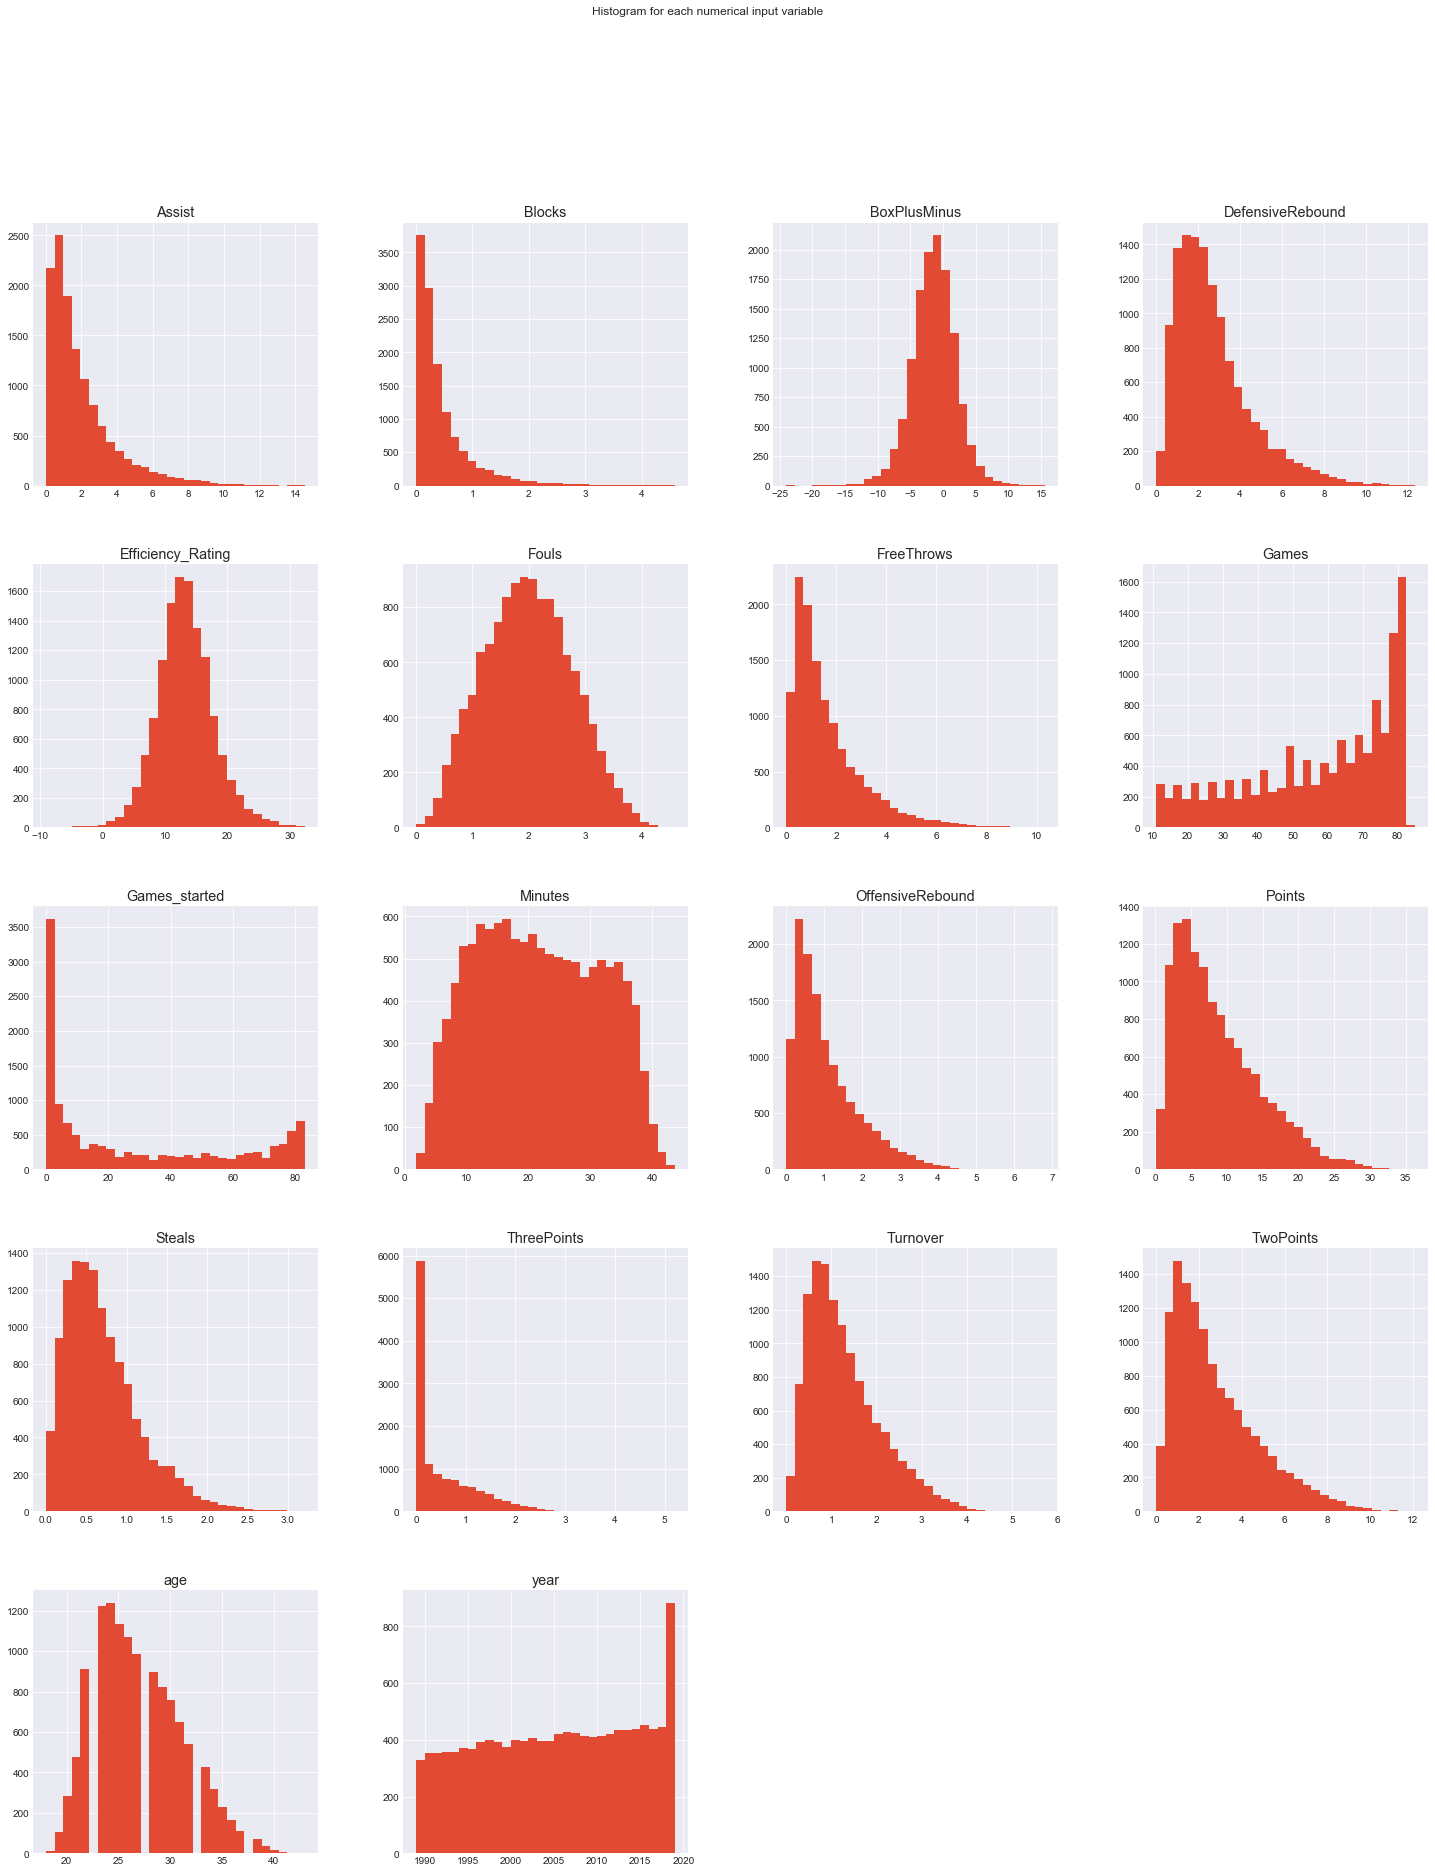

In [472]:
import pylab as pl
df_pergame.drop(['Player','Position', 'Team', 'cle', 'isAllNBA'] ,axis=1).hist(bins=30, figsize=(25,30))#enleve les variables non numériques
pl.suptitle("Histogram for each numerical input variable")
plt.show()

Aussi, on peut également voir si certaines équipes se démarquent en ayant plus de joueurs All NBA que d'autres. En regardant, le nombre de All NBA que chaque équipe a eu, on peut se rendre compte que la NBA en tant que ligue est pluôt équilibré. Ainsi, peu d'équipe semblent se démarquer. Cela montre que les systèmes mis en place autour de la ligue comme les draft ont un réel effet et permettent d'avoir de bons joueurs dans chaque franchise. 

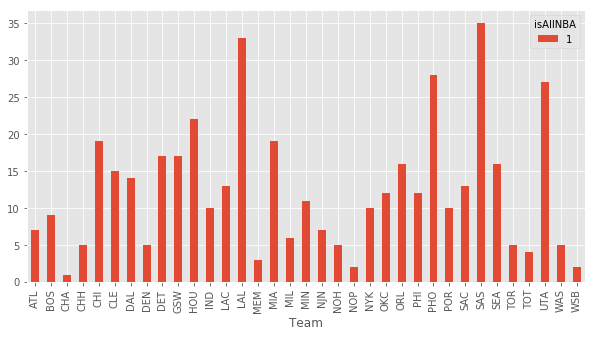

In [50]:
pd.crosstab(df_pergame.Team,df_pergame[df_pergame['isAllNBA']==1].isAllNBA).plot(kind='bar',figsize=(10,5)) #quelle équipe a eu le plus de all NBA

### &emsp;2.2.Comparaisons All NBA/Average Player

Tout d'abord, il peut être intéressant de voir la répartition de nos données à savoir la proportion de joueurs All NBA dans notre dataset. En regardant de plus près on se rend compte que notre dataset est clairement imbalanced avec 97% de joueurs non All NBA pour seulement 3% de All NBA.

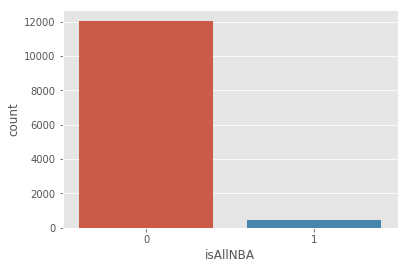

In [48]:
sns.countplot(x='isAllNBA',data=df_pergame)

In [49]:
count_allNBA=len(df_pergame[df_pergame['isAllNBA']==1])
count_notNBA=len(df_pergame[df_pergame['isAllNBA']==0])


Pourcentage_allNBA=count_allNBA/(count_allNBA+count_notNBA)
Pourcentage_notallNBA=count_notNBA/(count_allNBA+count_notNBA)
print("Pourcentage de joueurs All NBA :", Pourcentage_allNBA*100)
print("Pourcentage de joueurs non all NBA :", Pourcentage_notallNBA*100)

Pourcentage de joueurs All NBA : 3.480278422273782
Pourcentage de joueurs non all NBA : 96.51972157772622


Les labels que l'on souhaite prédire sont composés de deux classes : sélectionnés ou pas. De fait, on remarque que le pourcentage de joueurs sélectionnés est faible dans notre dataset comparés aux autres joueurs. On pouvait s'attendre à un tel type de résultat. Cependant, si l'on fais des modèles de machine learning-et notamment de classification- ce déséquilibre peut nuire à l'apprentissage. De plus, si l'on évalue la qualité du modèle par l'erreur de prédiction, on a plus de chance de faire des erreurs de type si les classes sont déséquilibrés. Une façon de régler ce problème est d'utiliser des algoritmes SMOTE "Synthetic Minority Over-sampling Technique". (https://arxiv.org/pdf/1106.1813.pdf : Journal of Artificial Intelligence Research 16) ou alors le sub sampling.

Nous détaillerons cela plus bas.

En terme de performance, on peut également voir que les joueurs All NBA sont tout de même assez impressionnant. Si l'on regarde les statistiques moyennes on peut voir de grandes disparités : 2 fois plus de rebonds captés, 16 minutes/48 jouées de plus en moyenne, 10 point de PER en plus, 4 assist par match de plus etc...

In [54]:
mean=['age', 'Minutes', 'Efficiency_Rating','ThreePoints', 'FreeThrows', 'Points', 'Assist','DefensiveRebound', 'Steals', 'Blocks', 'Turnover', 'Fouls']

all_nba=[]
no_all_nba=[]
df_mean_all={}
df_mean_noall={}

for i in mean:
    all_nba.append(round(df_pergame[df_pergame.isAllNBA==1][i].mean(),1))
    no_all_nba.append(round(df_pergame[df_pergame.isAllNBA==0][i].mean(),1))
    
i=0
for j in mean:
    df_mean_all[j]=all_nba[i]
    i+=1
    
df_mean_all["Per Game"]="All NBA"

    
i=0
for j in mean:
    df_mean_noall[j]=no_all_nba[i]
    i+=1    

df_mean_noall["Per Game"]="No All NBA"   

df_mean=[df_mean_all,df_mean_noall]

        
df_mean=pd.DataFrame(df_mean)
df_mean.set_index("Per Game",inplace=True)

df_mean

,Assist,Blocks,DefensiveRebound,Efficiency_Rating,Fouls,FreeThrows,Minutes,Points,Steals,ThreePoints,Turnover,age
Per Game,,,,,,,,,,,,
All NBA,5.0,1.1,5.8,23.4,2.6,5.2,37.0,22.5,1.4,0.9,2.8,27.3
No All NBA,1.9,0.4,2.6,12.9,2.0,1.5,21.0,8.3,0.7,0.5,1.2,26.9


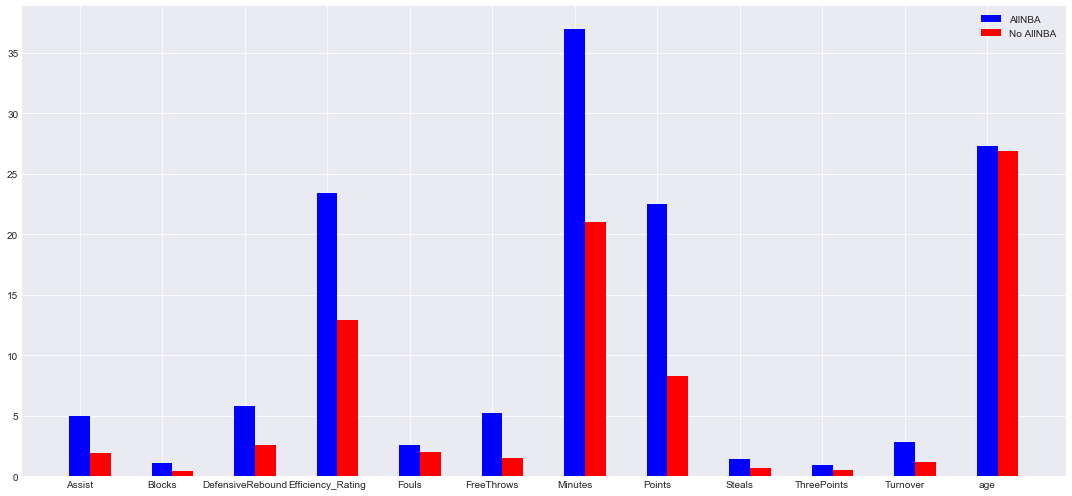

In [475]:
X = np.arange(len(df_mean.columns))
plt.figure(figsize=(15,7))

ax1=plt.bar(X + 0.00, df_mean.values[0], color = 'b', width = 0.25,label='AllNBA')
ax2=plt.bar(X + 0.25, df_mean.values[1], color = 'r', width = 0.25,label='No AllNBA')
plt.xticks(X, df_mean.columns)

plt.legend()
plt.tight_layout()

plt.show()

Cet écart entre les joueurs All NBA et les joueurs moyen peut également se voir graphiquement en dessinant une matrice de scatter plot. On voit ainsi se former dans la plupart des graphes une frontière entre les joueurs moyens et les joueurs All NBA montrant ainsi une réelle domination au niveau des statistiques. Ce graphique a également l'avantage de nous orienter vers les kNN dans les algorithmes puisque l'on voit que l'argument géométrique(distances) permet de classifier les joueurs.

La matrice de nuage de points nous permets de représenter nos données tout en identifiant les labels que l'on souhaite prédire. Comme on pouvait s'y attendre les joueurs All NBA occupent majoritairement les quarts Nord-Est des graphiques i.e des bonnes stats dans les deux variables. Cependant, cela nous permet aussi de voir que les séparations ne sont pas distinctes comme dans les manuels mais que les masses se touchent et que certains joueurs All-NBA peuvent se retrouver près dans les masses des joueurs non sélectionnées. 

Text(0.5,0.98,'Matrice de nuages de points avec flag joueurs ALL NBA')

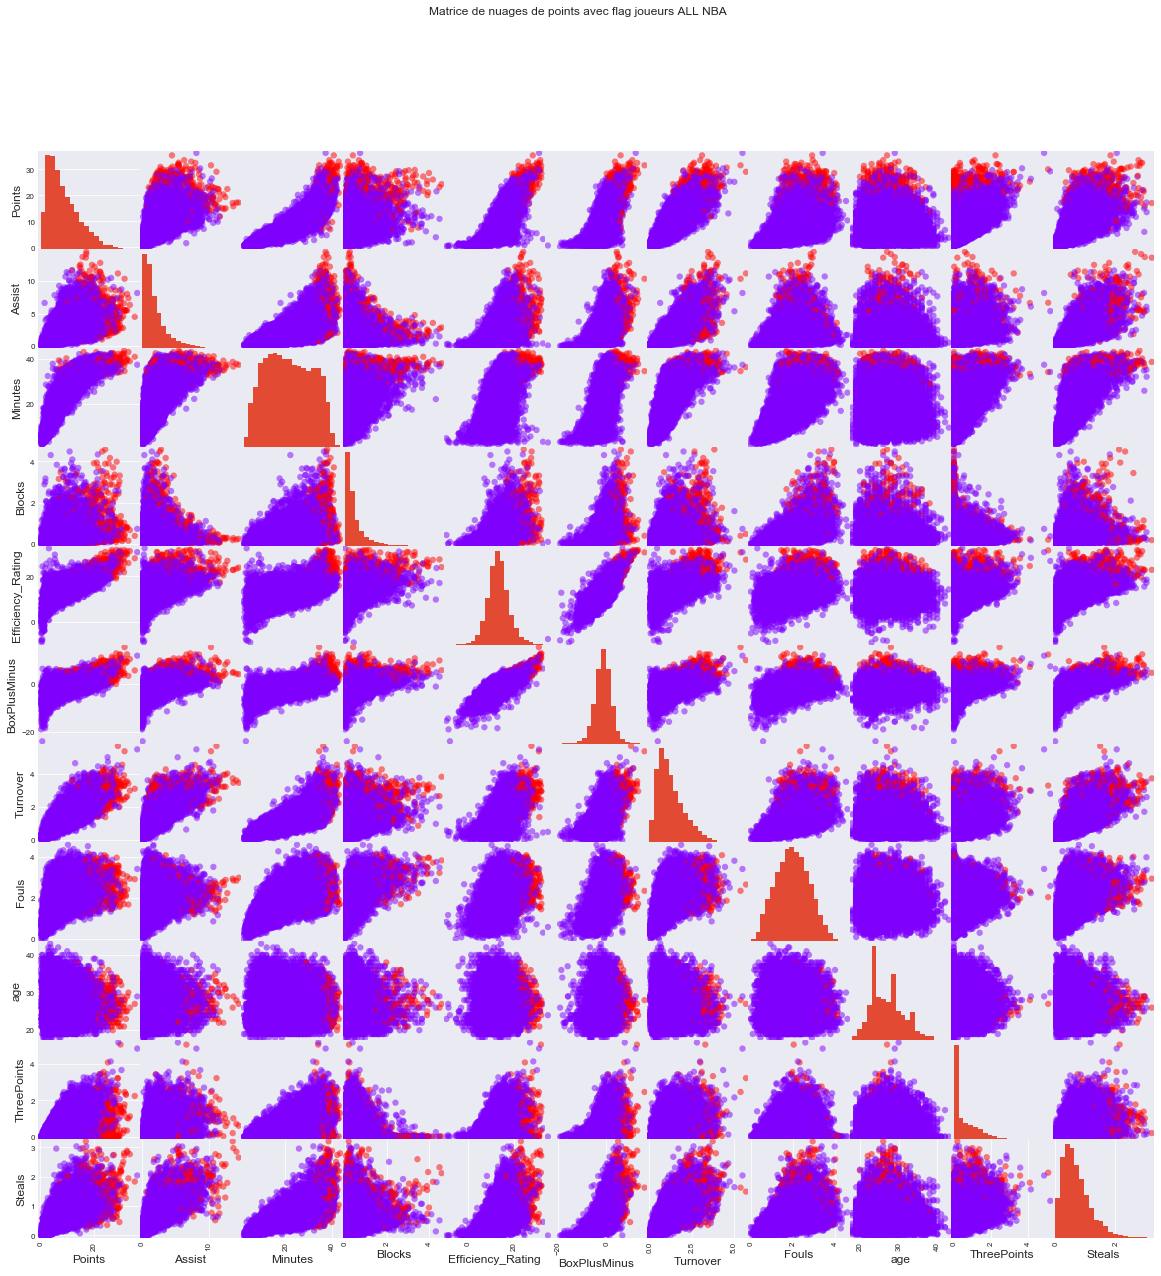

In [473]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
X = df_pergame[feature_names]
feature_names = ['Efficiency_Rating', 'BoxPlusMinus', 'TwoPoints', 'ThreePoints', 'FreeThrows', 'Steals', 'Blocks', 'Turnover']#features retenus
y = df_pergame['isAllNBA']#label à colorier
cmap = cm.get_cmap('rainbow')
scatter = pd.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':20}, figsize=(20,20), cmap = cmap)
plt.suptitle('Matrice de nuages de points avec flag joueurs ALL NBA')


On peut également comparer variables par variables les densités. Ici, on regarde la distribution des points marqués en fonction de la classe de joueur. On remarque ainsi que les joueurs All NBA sont plus centrés autour de 20 points/ matchs quand le joueur moyen est autour de 5/matchs.

C:\Users\Raviraj\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


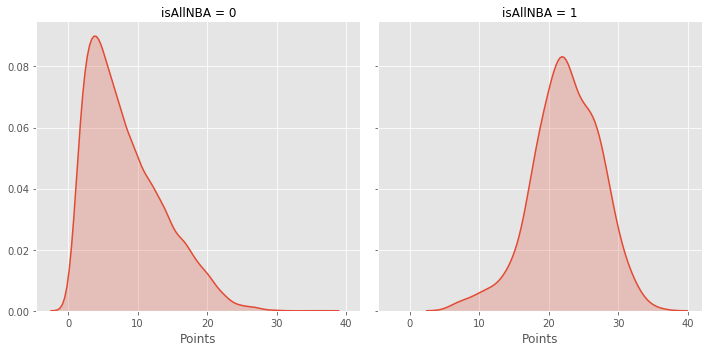

In [53]:
g = sns.FacetGrid(df_pergame, col="isAllNBA",legend_out=True,size=5)
g.map(sns.kdeplot, "Points",shade=True);


### &emsp;2.3.Relations intéressantes

Ici, nous allons tenter de montrer quelque relations intéressantes à nos yeux. On regarde la courbe des points et du PER en fonction de l'âge et on se rend compte que ces courbes sont décroissantes avec un potentiel max du joueur atteint en général vers l'age de 27-28 ans. Ainsi, on devrait s'attendre à ce que l'age fasse décroitre la probabilité d'être sélectionné All NBA.

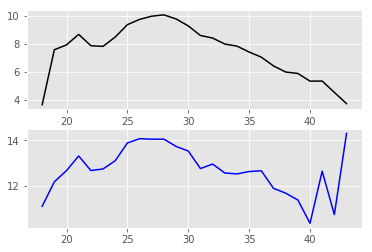

In [52]:
df = pd.DataFrame(df_pergame)

plt.subplot(211)#premier graph en haut
plt.plot(df.groupby("age")["Points"].mean(),'k')#points en fonction de l'âge
plt.subplot(212)#deuxième graph en bas
plt.plot(df.groupby("age")["Efficiency_Rating"].mean(),'b')# PER en fonction de l'age

In [474]:
sns.pairplot(df_pergame, vars=["Points","Minutes","Efficiency_Rating"],hue="isAllNBA",height=3)

TypeError: pairplot() got an unexpected keyword argument 'height'

### &emsp;2.4.Matrice de corrélation

In [58]:
correlation = df_pergame.drop(['Player','Position', 'Team', 'cle','OffensiveRebound'] ,axis=1).corr()
correlation.style.background_gradient()


,age,year,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,TwoPoints,ThreePoints,FreeThrows,Points,Assist,DefensiveRebound,Steals,Blocks,Turnover,Fouls,isAllNBA
age,1,-0.0638259,0.0224647,0.0352989,0.0583194,-0.0175941,0.100115,-0.0306553,0.0522794,-0.0254051,-0.00981193,0.0576739,0.0493112,0.00569593,-0.0361227,-0.0336604,0.0122983,0.0204812
year,-0.0638259,1,-0.118118,-0.0540241,-0.0232249,0.0170151,0.0426011,-0.12419,0.26953,-0.0856694,-0.016841,-0.0395035,0.0514607,-0.0832259,-0.0292626,-0.101342,-0.14958,-0.0357692
Games,0.0224647,-0.118118,1,0.590641,0.599907,0.409344,0.513332,0.469777,0.229595,0.400558,0.488308,0.340778,0.421812,0.434971,0.241399,0.433041,0.489922,0.153721
Games_started,0.0352989,-0.0540241,0.590641,1,0.834852,0.525678,0.586056,0.719563,0.303322,0.632171,0.73668,0.530767,0.651149,0.615541,0.374048,0.686671,0.590642,0.296038
Minutes,0.0583194,-0.0232249,0.599907,0.834852,1,0.63392,0.687192,0.828948,0.457803,0.763953,0.892457,0.65031,0.7146,0.754256,0.351041,0.825299,0.678242,0.298694
Efficiency_Rating,-0.0175941,0.0170151,0.409344,0.525678,0.63392,1,0.798234,0.755286,0.251704,0.740365,0.769952,0.476714,0.615422,0.541485,0.403989,0.616245,0.414988,0.421147
BoxPlusMinus,0.100115,0.0426011,0.513332,0.586056,0.687192,0.798234,1,0.591986,0.354873,0.591463,0.657412,0.49088,0.607342,0.654512,0.409466,0.54066,0.499755,0.365398
TwoPoints,-0.0306553,-0.12419,0.469777,0.719563,0.828948,0.755286,0.591986,1,0.140277,0.842885,0.923772,0.507322,0.712971,0.606368,0.432115,0.807135,0.611005,0.428663
ThreePoints,0.0522794,0.26953,0.229595,0.303322,0.457803,0.251704,0.354873,0.140277,1,0.287451,0.488941,0.430787,0.0674316,0.403838,-0.192194,0.331812,0.048399,0.10518
FreeThrows,-0.0254051,-0.0856694,0.400558,0.632171,0.763953,0.740365,0.591463,0.842885,0.287451,1,0.902977,0.539199,0.603456,0.592908,0.320547,0.810735,0.511903,0.473658


Nous pouvons également regarder les corrélations entre les variables grâce à la matrice de corrélation. Cette matrice ressemble à la heatmap que l'on a pu réaliser dans la partie 1 mais elle a l'avantage de faire apparaitre les corrélations numériquement.
Idéalement, nous aurions voulu utiliser cette matrice de corrélation pour peut être discriminer les variables que l'on va utiliser dans les possibles modèles de machine learning. Cependant, le problème est que la variable que l'on désire prédire est une variable catégorique que l'on encoder avec des 1 si le joueur est All NBA et 0 sinon. Ainsi, la corrélation standard (Pearson)  ne semble pas une bonne mesure pour étudier le lien entre deux variables. 
En faisant des recherches, nous avons vu que si nous souhaitons étudier le lien entre deux variables et que l'une des deux est une variable catégorique il y a deux méthodes : -faire une régression logistique ou - Calculer une Point Biserial correlation. (https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

Nous optons pour faire une régression logistique dans la partie modèle de machine Learning. En effet, la régression logistique a pour avantage de prédire des variables catégoriques en donnant des probabilités. Ainsi, nous pourrons comprendre les relations grâce à la régression et creuser plus en détails certaines relations que l'on a vu dans cette partie exploratoire.


# 3. Modèles de Machine Learning

Dans cette partie, nous allons essayer de faire des modèles de Machine Learning afin de prédire quels sont les joueurs qui pourront éventuellement être sélectionnés All NBA. Pour cela nous proposons trois méthodes différentes.

La première consistera à faire une régression logistique, la régression logistique est en effet assez adapté aux problèmes de classification puisqu'elle permet de prédire une variable catégorique. Aussi, cela nous permettra d'estimer des probabilités et de voir l'impact de nos features sur la sélection.

Ensuite, nous appliquerons un modèle plus orienté "Machine Learning" : le Random Forest. Cet algorithme génère plusieurs arbres et les agrège pour donner une prédiction plus précise. La possibilité d'avoir un arbre et des seuils sur chacune de nos variables à particulièrement motivé le choix de cet algorithme. 

Enfin, nous appliquerons l'algorithme kNN ou "Plus proches voisin" pour comparer avec les résultats de l'approche précédente. Cet algorithme a en effet l'avantage d'être robuste aux données bruitées. De plus, la partie 2 et les différentes visualisations qu'on a pu effectuer nous ont montré que l'on a une frontière qui se dessine plutot bien dans les scatter plot entre joueurs All NBA et Non All NBA. Un algorithme se basant sur des arguments géométriques comme le kNN pourrait donc être intéressant

## 3.1. Logistic Regression

On peut d'abord préparer les données, pour cela nous allons procéder à la cross validation en séparant l'échantillon en train/test. 


In [364]:
from sklearn.model_selection import train_test_split

df=df_pergame.drop(['Player', 'Team', 'cle'] ,axis=1)
stacked = df[['Position']].stack()
df['Position']=pd.Series(stacked.factorize()[0], index=stacked.index).unstack()

X = df.loc[:, df.columns != 'isAllNBA']
Y = df.loc[:, df.columns == 'isAllNBA']


nba_train=df_pergame[df_pergame.year<2010]
nba_test=df_pergame[df_pergame.year>2010]
X_train=nba_train[['Games','Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','OffensiveRebound', 'DefensiveRebound','Steals']]  # Features
y_train=nba_train['isAllNBA']
X_test=nba_test[['Games','Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','OffensiveRebound', 'DefensiveRebound','Steals']]
y_test=nba_test['isAllNBA']

Une fois la cross validation faite, on peut procéder à faire la régression. Pour cela, nous allons faire la régression sur les données train puis effectuer les prédictions sur les données test. 

Dans un premier temps, nous allons procéder à des régressions univariées afin de voir la relation entre chaque variable et la sélection All NBA. Nous allons prédire des probabilités en s'aidant de la fonction sigmoid qui permet de calculer des probabilités à partir des coefficients estimés.

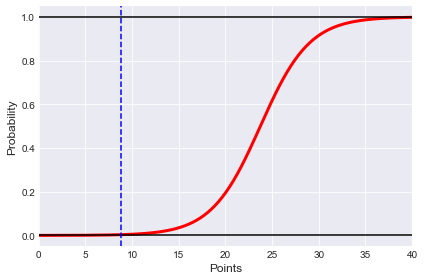

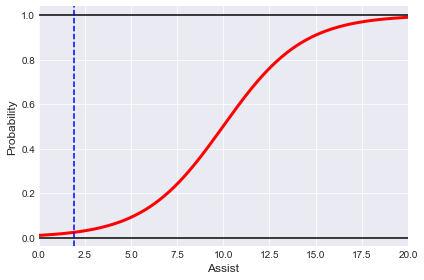

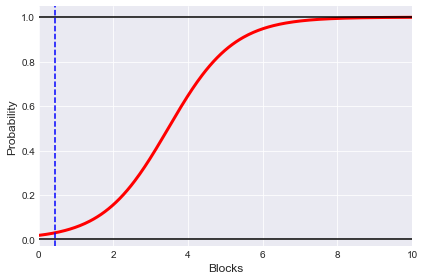

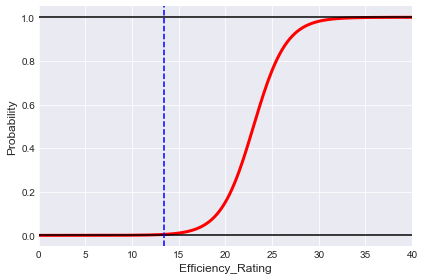

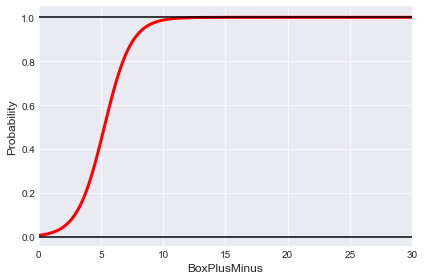

In [415]:
from sklearn.linear_model import LogisticRegression

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) #fonction sigmoid pour obtenir les probas
def regression_univariee(variable, borne_debut, borne_fin): #fonction permettant d'obtenir une régression et le graph associée
    moyenne=np.mean(X_test[variable])
    X=np.reshape(X_train[variable],(len(X_train[variable]),1))
                 
    y=np.reshape(y_train, (len(y_train),1)) #reshape car une seule variable
    clf = LogisticRegression(random_state=0).fit(X, y)# fit la régression sur les données train

    clf.predict_proba(np.reshape(X_test[variable],(len(X_test[variable]),1))) # predit une proba
    X_abs = np.linspace(borne_debut, borne_fin, 300) #crée une échelle abscisses
    proba = sigmoid(X_abs * clf.coef_ + clf.intercept_).ravel()#calcul des probabilités pour chaque point
    sns.set_style("darkgrid")
    #graph
    plt.plot(X_abs, proba, color='red', linewidth=3)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.axhline(y=1, color='k', linestyle='-')
    plt.axvline(x=moyenne, color='b', linestyle='--')
    plt.ylabel('Probability')
    plt.xlabel(variable)
    plt.xlim(borne_debut, borne_fin)
    plt.tight_layout()

    plt.show()

#regression par rapport à chaque variable    
regression_univariee('Points', 0,40)
regression_univariee('Assist', 0,20)
regression_univariee('Blocks',0,10)
regression_univariee('Efficiency_Rating',0,40)
regression_univariee('BoxPlusMinus', 0,30)

Nous pouvons voir grâce à ces graphiques la distribution de probabilité d'être sélectionné en fonction de chaque variable. Ainsi, on peut voir grâce à la ligne bleue qui représente la moyenne des joueurs que souvent être autour de la moyenne implique une faible probabilité d'être sélectionné. Il faut par exemple un PER supérieur à 24 pour avoir plus de 50% de chance d'être sélectionné. De la même manière on peut voir qu'un joueur qui aurait un average de double-double(20 points et 10 assists) a 50% de chance d'être sélectionné. On comprend donc un peu plus les ordres de grandeur a atteindre sur chaque variable pour être sélectionné. Ainsi, les variables défensives ne sont pas particulièrement importantes, ici 2.5 block/match par exemple permettent d'avoir plus de 50% de chance d'être sélectionné. Ce seuil n'apparait pas comme particulièrement élevé en comparaison aux variables offensives.

Nous allons ensuite procéder à une régression multivariées avec l'ensemble des features dont l'on dispose. Cependant, nous disposons de beaucoup de features dont certaines n'ont probablement pas beaucoup d'intérêt. Nous allons donc utiliser le package feature_selection de sklearn pour voir quelles variables nous pourrions éventuellement nous passer dans l'analyse.

In [366]:
X=['age','Games_started','Minutes','Points','Assist',
 'OffensiveRebound',
 'DefensiveRebound',
 'Steals',
 'Blocks',
 'Turnover',
 'Fouls']
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg,20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

variables=['age','Games','Minutes','Points','Assist','BoxPlusMinus',
 'Steals',
 'Blocks',
 'Turnover',
 'Fouls',
  'DefensiveRebound',
    'OffensiveRebound']

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Toutes les variables semblent être pertinentes pour l'analyse, cependant nous allons enlever certaines qui nous paraissent redondantes. D'une part nous enlevons les variables corrélés entre elles : nous gardons uniquement la variable points total et enlevons 2P% et 3P%. La variable PER est également calculée à partir de toutes les autres donc nous l'enleverons dans cette régression. L'idée est de voir réellement ce que chaque variable peut apporter à la sélection All NBA.

In [367]:
X=X_train[variables]
y=y_train

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X, y)
clf.coef_
y_pred=clf.predict(X_test[variables])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #précision 97% ne permet pas de juger
clf.predict_proba(X_test[variables])

odds=np.exp(clf.coef_)
df=pd.DataFrame(odds)
df.columns=variables
df

Accuracy: 0.9748985801217038


,age,Games,Minutes,Points,Assist,BoxPlusMinus,Steals,Blocks,Turnover,Fouls,DefensiveRebound,OffensiveRebound
0,1.039607,1.02013,0.975468,1.189042,1.16237,1.27697,0.987447,1.382031,1.201412,0.642933,1.184288,1.052653


Nous avons ici calculé les odd ratios qui sont les exponentielles des coefficients. Cela nous permet comme en économétrie d'avoir une interprétation des coefficients plus intuitives. Ainsi, on a par exemple que la chance d'être sélectionné All NBA augmente de 1.19 à chaque point marqué ou de 1 à chaque match gagné mais diminue de 0.63 pour chaque faute additionnelle commise. On obtient ainsi des relations intéressantes tels que le fait que la chance d'être sélectionné diminue avec l'âge bien que certaine nous semble étrange tel que le fait le nombre de steal diminue la probabilité d'être sélectionné.

Maintenant que la régression a été faite nous sommes également en mesure de prédire les 15 joueurs qui vont être sélectionné.

In [368]:
proba=pd.DataFrame(clf.predict_proba(X_test[variables]), columns=clf.classes_)
p1=proba.loc[:,1]
nba_test = nba_test.assign(Proba1=p1.values)
test2019LR=nba_test.loc[nba_test['year'] == 2019]
test2018LR=nba_test.loc[nba_test['year'] == 2018]


test2019LR.nlargest(15, columns=['Proba1'])
test2018LR.nlargest(15, columns=['Proba1']) 

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,Assist,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle,isAllNBA,Proba1
11832,LeBron James,PF,33,2018,CLE,82.0,82.0,36.902439,28.6,9.6,...,9.109756,1.182927,7.463415,1.414634,0.865854,4.231707,1.658537,CLE2018LeBron James,0,0.999859
11787,James Harden,SG,28,2018,HOU,72.0,72.0,35.430556,29.8,10.9,...,8.750000,0.569444,4.833333,1.750000,0.694444,4.375000,2.347222,HOU2018James Harden,0,0.999691
12054,Russell Westbrook,PG,29,2018,OKC,80.0,80.0,36.425000,24.7,8.2,...,10.250000,1.900000,8.150000,1.837500,0.250000,4.762500,2.500000,OKC2018Russell Westbrook,0,0.998860
11724,Anthony Davis,PF,24,2018,NOP,75.0,75.0,36.360000,28.9,5.2,...,2.320000,2.493333,8.600000,1.533333,2.573333,2.160000,2.120000,NOP2018Anthony Davis,0,0.987949
11741,Kevin Durant,PF,29,2018,GSW,68.0,68.0,34.191176,26.0,5.6,...,5.382353,0.455882,6.367647,0.735294,1.750000,3.044118,1.955882,GSW2018Kevin Durant,0,0.983964
11877,Damian Lillard,PG,27,2018,POR,73.0,73.0,36.575342,25.2,6.7,...,6.589041,0.849315,3.602740,1.054795,0.369863,2.821918,1.602740,POR2018Damian Lillard,0,0.972320
11631,Giannis Antetokounmpo,PF,23,2018,MIL,75.0,75.0,36.746667,27.3,5.8,...,4.813333,2.080000,7.960000,1.453333,1.413333,2.973333,3.080000,MIL2018Giannis Antetokounmpo,0,0.966199
11722,Stephen Curry,PG,29,2018,GSW,51.0,51.0,31.980392,28.2,8.6,...,6.078431,0.705882,4.411765,1.568627,0.156863,3.000000,2.235294,GSW2018Stephen Curry,0,0.964014
11715,DeMarcus Cousins,C,27,2018,NOP,48.0,48.0,36.187500,22.6,5.5,...,5.354167,2.187500,10.666667,1.645833,1.583333,5.041667,3.812500,NOP2018DeMarcus Cousins,0,0.961035
11846,Nikola Jokic,C,22,2018,DEN,75.0,73.0,32.573333,24.4,7.1,...,6.106667,2.600000,8.106667,1.200000,0.813333,2.800000,2.826667,DEN2018Nikola Jokic,0,0.815237


In [369]:
predictions=pd.DataFrame(y_pred)
nba_test = nba_test.assign(Predictions=predictions.values)

On peut essayer de voir les erreurs qu'à fait l'algorithme et ainsi d'investiguer sur les erreurs de classification. Dans un premier temps regardons les erreurs False Negative c'est à dire de regarder là ou l'algorithme a classé les joueurs comme étant non All NBA alors qu'ils l'ont été.

In [370]:
nba_test.loc[(nba_test['isAllNBA'] == 1) & (nba_test['Predictions'] == 0)]

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle,isAllNBA,Proba1,Predictions
8560,LaMarcus Aldridge,PF,25,2011,POR,81.0,81.0,39.641975,21.5,2.4,...,3.432099,5.320988,1.012346,1.160494,1.888889,2.716049,POR2011LaMarcus Aldridge,1,0.168681,0
8712,Manu Ginobili,SG,33,2011,SAS,80.0,79.0,30.325000,21.7,5.3,...,0.525000,3.162500,1.537500,0.350000,2.175000,2.037500,SAS2011Manu Ginobili,1,0.336111,0
8752,Al Horford,C,24,2011,ATL,77.0,77.0,35.116883,20.7,4.4,...,2.363636,6.961039,0.766234,1.038961,1.545455,2.506494,ATL2011Al Horford,1,0.113584,0
8863,Chris Paul,PG,25,2011,NOH,80.0,80.0,36.000000,23.7,6.4,...,0.475000,3.612500,2.350000,0.062500,2.212500,2.450000,NOH2011Chris Paul,1,0.369546,0
8881,Zach Randolph,PF,29,2011,MEM,75.0,74.0,36.320000,22.6,2.5,...,4.346667,7.840000,0.840000,0.333333,2.013333,2.333333,MEM2011Zach Randolph,1,0.248479,0
8913,Amar'e Stoudemire,C,28,2011,NYK,78.0,78.0,36.794872,22.7,0.7,...,2.538462,5.615385,0.910256,1.923077,3.205128,3.512821,NYK2011Amar'e Stoudemire,1,0.365210,0
8989,Carmelo Anthony,SF,27,2012,NYK,55.0,55.0,34.109091,21.1,2.9,...,1.600000,4.654545,1.127273,0.436364,2.618182,2.836364,NYK2012Carmelo Anthony,1,0.125472,0
9040,Andrew Bynum,C,24,2012,LAL,60.0,60.0,35.200000,22.9,1.8,...,3.200000,8.616667,0.450000,1.933333,2.533333,1.733333,LAL2012Andrew Bynum,1,0.238828,0
9051,Tyson Chandler,C,29,2012,NYK,62.0,62.0,33.241935,18.7,4.1,...,3.419355,6.451613,0.903226,1.435484,1.645161,3.000000,NYK2012Tyson Chandler,1,0.009109,0
9134,Blake Griffin,PF,22,2012,LAC,66.0,66.0,36.242424,23.4,4.1,...,3.303030,7.560606,0.818182,0.727273,2.272727,3.272727,LAC2012Blake Griffin,1,0.203099,0


In [371]:
group=nba_test.loc[(nba_test['isAllNBA'] == 1) & (nba_test['Predictions'] == 0)].groupby('Position')
for key, item in group:
    print(group.get_group(key), "\n\n")


                  Player Position  age  year Team  Games  Games_started  \
8752          Al Horford        C   24  2011  ATL   77.0           77.0   
8913   Amar'e Stoudemire        C   28  2011  NYK   78.0           78.0   
9040        Andrew Bynum        C   24  2012  LAL   60.0           60.0   
9051      Tyson Chandler        C   29  2012  NYK   62.0           62.0   
9542          Marc Gasol        C   28  2013  MEM   80.0           80.0   
9590       Dwight Howard        C   27  2013  LAL   76.0           76.0   
10038      Dwight Howard        C   28  2014  HOU   71.0           71.0   
10051       Al Jefferson        C   29  2014  CHA   73.0           73.0   
10149        Joakim Noah        C   28  2014  CHI   80.0           80.0   
10432         Marc Gasol        C   30  2015  MEM   81.0           81.0   
10515     DeAndre Jordan        C   26  2015  LAC   82.0           82.0   
10842     Andre Drummond        C   22  2016  DET   81.0           81.0   
10951     DeAndre Jordan 

Nous voyons que le groupe qui se distingue le plus est celui des 'C' soit Center dont l'atout est surtout la défense. Finalement, à part les rebonds et les blocks nous avons mis peu de variables défensives dans notre régression et on manque ainsi peut être quelques informations.

De plus, bien que ne mettant pas beaucoup de points les pivots modernes qui fournissent beaucoup de travail sur le terrain sont de plus en plus appréciés mais encore cela ne se voit que très peu sur les données puisqu'ils ont peu de points, peu d'assists, faible % au tir. Ainsi, pour améliorer nos prédictions et être en phase avec la NBA moderne il aurait été bien d'avoir une variable "effort" pouvant se mesurer quantitativement par les distances parcourus par exemple.


In [372]:
nba_test.loc[(nba_test['isAllNBA'] == 0) & (nba_test['Predictions'] == 1) & (nba_test['year'] != 2018) & (nba_test['year'] !=2019)]


,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle,isAllNBA,Proba1,Predictions
8725,Blake Griffin,PF,21,2011,LAC,82.0,82.0,37.951220,21.9,3.2,...,3.292683,8.768293,0.768293,0.548780,2.719512,3.073171,LAC2011Blake Griffin,0,0.525713,1
8807,Kevin Love,PF,22,2011,MIN,73.0,73.0,35.767123,24.3,3.7,...,4.520548,10.712329,0.616438,0.383562,2.123288,2.027397,MIN2011Kevin Love,0,0.594881,1
9500,Stephen Curry,PG,24,2013,GSW,78.0,78.0,38.243590,21.3,5.4,...,0.756410,3.269231,1.615385,0.153846,3.076923,2.538462,GSW2013Stephen Curry,0,0.626200,1
9859,Carmelo Anthony,PF,29,2014,NYK,77.0,77.0,38.727273,24.4,3.6,...,1.883117,6.194805,1.233766,0.662338,2.571429,2.909091,NYK2014Carmelo Anthony,0,0.790311,1
9938,DeMarcus Cousins,C,23,2014,SAC,71.0,71.0,32.366197,26.1,4.7,...,3.070423,8.633803,1.535211,1.281690,3.535211,3.802817,SAC2014DeMarcus Cousins,0,0.664846,1
10263,Russell Westbrook,PG,25,2014,OKC,46.0,46.0,30.695652,24.7,6.4,...,1.195652,4.521739,1.913043,0.152174,3.847826,2.260870,OKC2014Russell Westbrook,0,0.688198,1
10406,Kevin Durant,SF,26,2015,OKC,27.0,27.0,33.814815,27.6,6.1,...,0.592593,6.000000,0.888889,0.925926,2.740741,1.481481,OKC2015Kevin Durant,0,0.810280,1
10540,Damian Lillard,PG,24,2015,POR,82.0,82.0,35.670732,20.7,5.1,...,0.597561,4.012195,1.182927,0.256098,2.707317,2.000000,POR2015Damian Lillard,0,0.604507,1
10869,Pau Gasol,C,35,2016,CHI,72.0,72.0,31.819444,21.7,4.0,...,2.152778,8.861111,0.583333,2.027778,2.277778,2.055556,CHI2016Pau Gasol,0,0.750630,1
10894,James Harden,SG,26,2016,HOU,82.0,82.0,38.109756,25.3,6.7,...,0.768293,5.341463,1.695122,0.621951,4.560976,2.792683,HOU2016James Harden,0,0.993742,1


En analysant les erreurs de classification False Positive, on se rend compte que notre modèle pourrait également être amélioré par une variable "nationalité". En effet, nous ne tenons pas à parler de discrimination mais il est vrai que pour les joueurs étrangers il y a un parcours plus important pour se faire reconnaitre par leurs paires. Ici, on le voit bien avec de très bon joueurs comme Karl Anthony Towns (probabilité de 89% mais non sélectionné) qui est Dominicain ou Pau Gasol & Marc Gasol, espagnols, Nikola Jokic qui est Serbe.

D'autre part, une des limites de notre approche est que l'on ne peut pas capter la popularité de ces joueurs et force est de constater que certains n'ont pas une popularité suffisante tel que des joeurs comme Cousins en 2017 impliqué dans des scandales, John Wall et Kemba Walker dont la taille ne permet pas d'être aussi apprécié que les autre Point Guards.

En outre, nous essayons ici de proposer des axes d'améliorations mais sommes conscients qu'il y aura forcément des erreurs de classification puisqu'il y a une part d'humain dans le sport qui reste non capturable par le machine Learning bien que l'analyse des données nous permet ici de tirer des relations bien intéressantes.

# 3.2. Random Forest Predictions

Nous allons procéder à la cross validation. Pour cela nous n'allons pas procéder à l'appel des packages train_test split comme usuellement mais plutôt découper le dataset en fonction des années. En effet, puisque nous allons essayer de prédire les équipes pour les années futures nous tenons à ce que le train soit plus fournie en data que le test. L'avantage étant que puisque l'on a beaucoup de données nous pouvons choisir un ratio de 2:1 tout en gardant une quantité respectable de données dans chaque data set.


In [373]:
nba_train=df_pergame[df_pergame.year<2010]
nba_test=df_pergame[df_pergame.year>2010]
#Arbitraire : à peu près deux fois plus de données dans le train que dans le test pour s'assurer d'avoir un bon 
print(nba_train.shape)
print(nba_test.shape)

(8140, 23)
(3944, 23)


In [374]:
X_train=nba_train[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]  # Features
y=nba_train['isAllNBA']


X_test=nba_test[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]
y_test=nba_test['isAllNBA']
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth = 3, n_estimators=100)

#Apprentissage sur les données train
clf.fit(X_train,y)
#Predictions sur les données test
y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

nba_test = nba_test.assign(Predictions=y_pred)

#calcul des différents types d'érreurs
nba_test['True Positive'] = np.where((nba_test['isAllNBA']==1) & (nba_test['Predictions']==1), 1, 0)
nba_test['True Negative'] = np.where((nba_test['isAllNBA']==0) & (nba_test['Predictions']==0), 1, 0)
nba_test['False Positive'] = np.where((nba_test['isAllNBA']==0) & (nba_test['Predictions']==1), 1, 0)
nba_test['False Negative'] = np.where((nba_test['isAllNBA']==1) & (nba_test['Predictions']==0), 1, 0)

TruePositive=sum(nba_test['True Positive'])
TrueNegative=sum(nba_test['True Negative'])
FalsePositive=sum(nba_test['False Positive']) 
FalseNegative=sum(nba_test['False Negative'])

array1=['TruePositive','True Negative', 'False Positive', 'False Negative']
array2=[TruePositive, TrueNegative, FalsePositive, FalseNegative]
#Mise en forme à l'aide du package pretty table
from prettytable import PrettyTable
t = PrettyTable(['Type', 'Number'])
t.add_row(['True Positive', TruePositive])
t.add_row(['True Negative', TrueNegative])
t.add_row(['False Positive', FalsePositive])
t.add_row(['False Negative', FalseNegative])

print(t)

from sklearn.metrics import f1_score
print("Le f1 score est ",f1_score(y_test, y_pred))

Accuracy: 0.9766734279918864
+----------------+--------+
|      Type      | Number |
+----------------+--------+
| True Positive  |   56   |
| True Negative  |  3796  |
| False Positive |   43   |
| False Negative |   49   |
+----------------+--------+
Le f1 score est  0.5490196078431372


En appliquant l'algorithme Random Forest sur notre dataset sans y apporter de travail, on peut voir que la précision est de 97% ce qui correspond à peu près à notre proportion de non All NBA. Ainsi, en classifiant tout en 0 on aurait une précision de 97%. Cette mesure de performance n'est pas satisfaisante. On peut en revanche calculer les erreurs de classifications et notamment si l'algorithme arrive à bien classifier les All NBA. Ici, on peut voir que notre prédiction n'est pas optimale puisque l'on a près de 40% de All NBA détecté (40 sur 105 possible).
On peut essayer d'améliorer le processus d'apprentissage notamment en essayant de proposer une solution au biais d'imbalance. 

Pour cela il existe deux solutions l'oversampling et l'undersampling. L'oversampling permet de créer des observations dans la classe minoritaire pour atteindre une proportion idéale. La méthode SMOTE permet notamment de faire ça en générant des observations en ce basant sur les plus proches voisins.
L'undersampling lui à l'inverse permet d'atteindre la proportion idéale en supprimant des observations de la classe majoritaire. 

Nous avons choisi d'utiliser l'undersampling du fait que l'oversampling rajoute des informations dans la classe minoritaire. Or la sélection All NBA est quelque chose d'unique et nous ne voulions pas polluer cette classe. L'undersampling lui permet de retirer des informations dans la classe majoritaire. Or cette classe est de base très fournie et le risque d'enlever des informations dans cette classe nous paraissait moins grand que celui de rajouter de l'information dans la classe majoritaire. Il s'agit cependant d'un choix.

Appliquons donc cette technique aux données train pour que l'algorithme puisse apprendre avec un dataset balanced puis testons sur les données train qui elles restent imbalanced afin d'évaluer les erreurs. Nous nous servirons du package imblearn qui fournit des solutions pour faire face aux données imbalanced.

In [375]:
X_train=nba_train[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]  # Features
y=nba_train['isAllNBA']

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y)

X_test=nba_test[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]
y_test=nba_test['isAllNBA']
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth = 6, n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_res,y_res)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) #On remarque déja une précision un peu moindre 


Accuracy: 0.941683569979716


In [376]:
nba_test = nba_test.assign(Predictions=y_pred)

nba_test['True Positive'] = np.where((nba_test['isAllNBA']==1) & (nba_test['Predictions']==1), 1, 0)
nba_test['True Negative'] = np.where((nba_test['isAllNBA']==0) & (nba_test['Predictions']==0), 1, 0)
nba_test['False Positive'] = np.where((nba_test['isAllNBA']==0) & (nba_test['Predictions']==1), 1, 0)
nba_test['False Negative'] = np.where((nba_test['isAllNBA']==1) & (nba_test['Predictions']==0), 1, 0)

TruePositive=sum(nba_test['True Positive'])
TrueNegative=sum(nba_test['True Negative'])
FalsePositive=sum(nba_test['False Positive']) 
FalseNegative=sum(nba_test['False Negative'])

array1=['TruePositive','True Negative', 'False Positive', 'False Negative']
array2=[TruePositive, TrueNegative, FalsePositive, FalseNegative]

from prettytable import PrettyTable
t = PrettyTable(['Type', 'Number'])
t.add_row(['True Positive', TruePositive])
t.add_row(['True Negative', TrueNegative])
t.add_row(['False Positive', FalsePositive])
t.add_row(['False Negative', FalseNegative])

print(t)
print("Le f1 score est ",f1_score(y_test, y_pred))

+----------------+--------+
|      Type      | Number |
+----------------+--------+
| True Positive  |  100   |
| True Negative  |  3614  |
| False Positive |  225   |
| False Negative |   5    |
+----------------+--------+
Le f1 score est  0.4651162790697675


On peut voir que en utilisant un dataset équilibré on perd en précision, cela se voit principalement sur les False Positive qui augmentent par rapport à précédemment. Cependant on arrive également à prédire plus de All NBA avec un bon ratio contrairement à auparavant. Ainsi le modèle semble plus convenir avec ces retraitements bien que le score de précision soit moindre.

[0.9771805273833671, 0.9759127789046653, 0.9756592292089249, 0.9759127789046653, 0.9756592292089249, 0.9756592292089249, 0.9746450304259635, 0.9754056795131846, 0.9748985801217038]


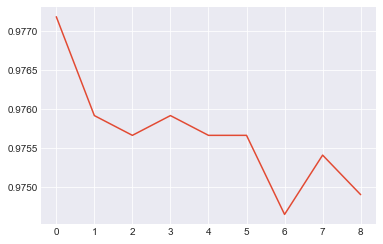

In [377]:
#Pour voir la convergence des scores
Score=[]

for i in range(1,10):
    clp=RandomForestClassifier(max_depth = i, n_estimators=100)
    clp.fit(X_train,y_train)
    y_pred2=clp.predict(X_test)
    Score.append(metrics.accuracy_score(y_test, y_pred2))
    
print(Score)
plt.plot(Score)

De plus on peut voir que l'arbre converge assez rapidement vers à peu près 10 itérations.

On peut également chercher à visualiser un des arbres de la random forest afin d'identifier les critères les plus intéressants et déterminants pour la sélection All NBA. Pour plus de lisibilité, on va limiter la profondeur de l'arbre à 3.

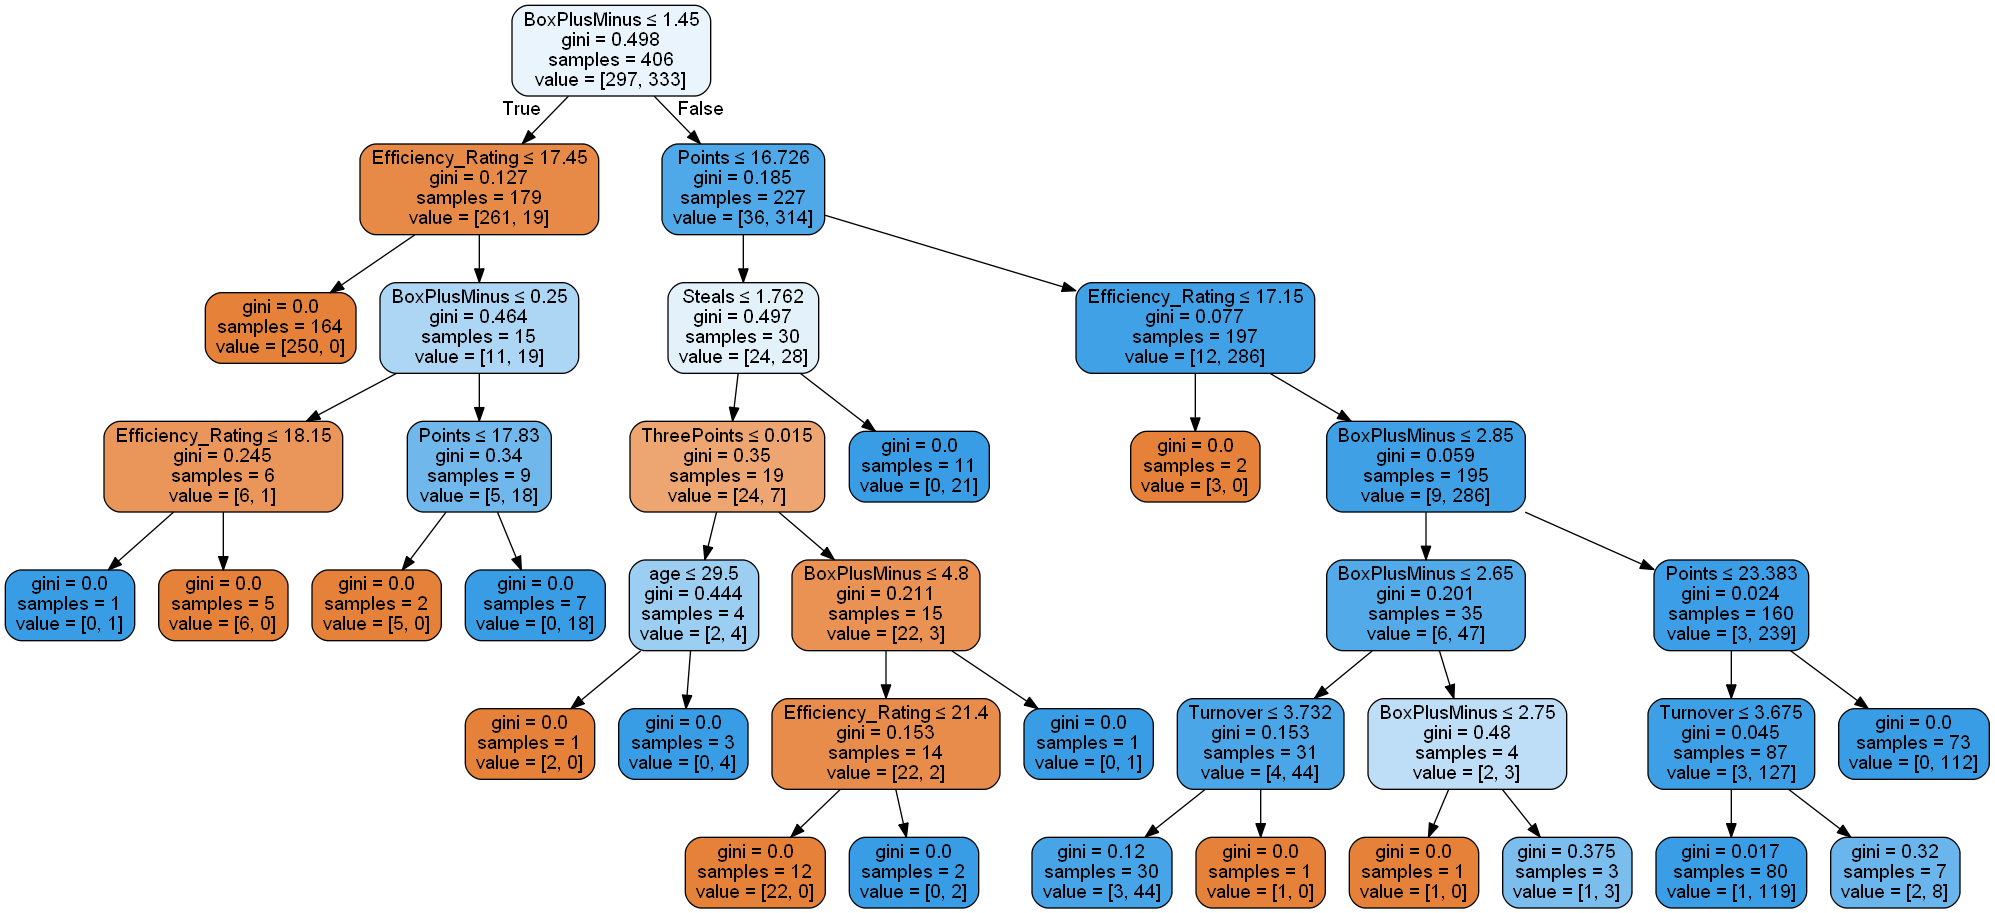

In [378]:
import os     

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

estimator=clf.estimators_[38]

feature_names = ['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']
class_names = ['isAllNBA']


export_graphviz(estimator, out_file=dot_data, feature_names=['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals'], 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Cette arbre nous permet d'identifier les seuils de chaque variable qui permettent de déterminer la sélection en ALL NBA. Ainsi on peut voir qu'il faut a minima 10 assists et 20 points par match pour finir dans cette équipe. En terme "basket ball", il faut averager le double-double sur la saison (définition :https://fr.wikipedia.org/wiki/Double-double). Au delà du fait de voir qu'il faut sortir d'assez grosses saisons pour finir All NBA on a maintenant des ordres de grandeurs permettant de quantifier les stats à sortir par un joueur pour finir All NBA. 

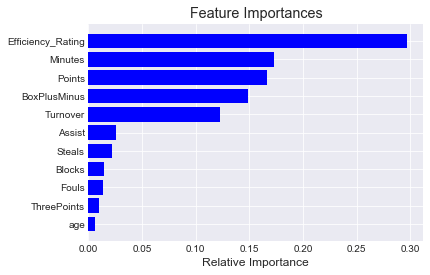

In [379]:
feature_names = ['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Le graphique ci dessus permet de visualiser les features les plus importants dans la prédiction. Ainsi, notre intuition sur le PER s'est révélée juste, il s'agit d'une variable clé. Aussi, le Box Plus Minus est également très importante, il s'agit d'une variable permettant d'évaluer la performance d'un joueur relativement aux autres et est très scrutée par les analystes (définition: https://en.wikipedia.org/wiki/Plus-minus).

On peut également chercher à prédire de réels output c'est à dire de prédire les joueurs sélectionnées. Il y a 15 joueurs sélectionnés par an et en l'état notre arbre ne nous permet pas de choisir ces 15 joueurs puisqu'il ne nous renvoie que des 0 ou des 1. Nous allons donc prédire des probabilités grâce au random forest et choisir les 15 joueurs ayant la probabilité la plus forte d'être sélectionné pour constituer les promotions 2018 et 2019 All NBA.

In [380]:
prediction_proba=clf.predict_proba(X_test)
proba=pd.DataFrame(clf.predict_proba(X_test), columns=clf.classes_)
p=proba.loc[:,1]
nba_test = nba_test.assign(Proba1=p.values)
nba_test

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,Turnover,Fouls,cle,isAllNBA,Predictions,True Positive,True Negative,False Positive,False Negative,Proba1
8555,Jeff Adrien,PF,24,2011,GSW,23.0,0.0,8.521739,11.3,-5.1,...,0.391304,1.217391,GSW2011Jeff Adrien,0,0,0,1,0,0,0.000033
8556,Arron Afflalo,SG,25,2011,DEN,69.0,69.0,33.681159,13.6,2.1,...,1.028986,2.217391,DEN2011Arron Afflalo,0,0,0,1,0,0,0.118280
8557,Alexis Ajinca,C,22,2011,TOT,34.0,2.0,10.000000,12.2,-3.4,...,0.529412,2.147059,TOT2011Alexis Ajinca,0,0,0,1,0,0,0.000107
8558,Solomon Alabi,C,22,2011,TOR,12.0,0.0,4.916667,2.0,-8.2,...,0.250000,0.416667,TOR2011Solomon Alabi,0,0,0,1,0,0,0.000033
8559,Cole Aldrich,C,22,2011,OKC,18.0,0.0,7.888889,7.0,-0.8,...,0.444444,1.666667,OKC2011Cole Aldrich,0,0,0,1,0,0,0.000033
8560,LaMarcus Aldridge,PF,25,2011,POR,81.0,81.0,39.641975,21.5,2.4,...,1.888889,2.716049,POR2011LaMarcus Aldridge,1,1,1,0,0,0,0.709866
8561,Malik Allen,PF,32,2011,ORL,18.0,0.0,9.888889,3.3,-3.9,...,0.166667,1.666667,ORL2011Malik Allen,0,0,0,1,0,0,0.000033
8562,Ray Allen,SG,35,2011,BOS,80.0,80.0,36.125000,16.4,3.6,...,1.462500,1.837500,BOS2011Ray Allen,0,0,0,1,0,0,0.351866
8563,Tony Allen,SG,29,2011,MEM,72.0,31.0,20.750000,18.3,3.6,...,1.194444,2.236111,MEM2011Tony Allen,0,0,0,1,0,0,0.213689
8564,Al-Farouq Aminu,SF,20,2011,LAC,81.0,14.0,17.925926,9.6,-3.0,...,1.271605,1.493827,LAC2011Al-Farouq Aminu,0,0,0,1,0,0,0.000186


In [381]:
nba_test2019RF=nba_test.loc[nba_test['year'] == 2019]
nba_test2018RF=nba_test.loc[nba_test['year'] == 2018]


nba_test2019RF.nlargest(15, columns=['Proba1'])
nba_test2018RF.nlargest(15, columns=['Proba1']) #Paul George, Joel Embiid, DeRozan, Aldridge All NBA mais pas sélectionnés par le modèle. Remplacé par Cousins, Paul, Irving, Jokic


,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,Turnover,Fouls,cle,isAllNBA,Predictions,True Positive,True Negative,False Positive,False Negative,Proba1
11631,Giannis Antetokounmpo,PF,23,2018,MIL,75.0,75.0,36.746667,27.3,5.8,...,2.973333,3.080000,MIL2018Giannis Antetokounmpo,0,1,0,0,1,0,0.997037
11946,Victor Oladipo,SG,25,2018,IND,75.0,75.0,34.026667,23.1,4.9,...,2.920000,2.333333,IND2018Victor Oladipo,0,1,0,0,1,0,0.995862
12054,Russell Westbrook,PG,29,2018,OKC,80.0,80.0,36.425000,24.7,8.2,...,4.762500,2.500000,OKC2018Russell Westbrook,0,1,0,0,1,0,0.995248
11741,Kevin Durant,PF,29,2018,GSW,68.0,68.0,34.191176,26.0,5.6,...,3.044118,1.955882,GSW2018Kevin Durant,0,1,0,0,1,0,0.993439
11832,LeBron James,PF,33,2018,CLE,82.0,82.0,36.902439,28.6,9.6,...,4.231707,1.658537,CLE2018LeBron James,0,1,0,0,1,0,0.991162
11724,Anthony Davis,PF,24,2018,NOP,75.0,75.0,36.360000,28.9,5.2,...,2.160000,2.120000,NOP2018Anthony Davis,0,1,0,0,1,0,0.985888
11877,Damian Lillard,PG,27,2018,POR,73.0,73.0,36.575342,25.2,6.7,...,2.821918,1.602740,POR2018Damian Lillard,0,1,0,0,1,0,0.983206
11722,Stephen Curry,PG,29,2018,GSW,51.0,51.0,31.980392,28.2,8.6,...,3.000000,2.235294,GSW2018Stephen Curry,0,1,0,0,1,0,0.977421
11846,Nikola Jokic,C,22,2018,DEN,75.0,73.0,32.573333,24.4,7.1,...,2.800000,2.826667,DEN2018Nikola Jokic,0,1,0,0,1,0,0.976286
11824,Kyrie Irving,PG,25,2018,BOS,60.0,60.0,32.183333,25.0,6.2,...,2.333333,2.033333,BOS2018Kyrie Irving,0,1,0,0,1,0,0.968764


## 3.3. k Neirest Neighbour

Nous allons finir cette partie par un dernier modèle celui des kNN. Cette approche statistique se base sur l'exploration que l'on a pu faire dans la partie 2. En effet, on a pu voir sur les graphiques une nette séparation entre les points All NBA et les autres points. De fait, nous pensons que l'algorithme kNN peut être intéressant.

In [382]:
#Cross Validation 
nba_train=df_pergame[df_pergame.year<2010]
nba_test=df_pergame[df_pergame.year>2010]
X_train=nba_train[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]  # Features
y=nba_train['isAllNBA']
X_test=nba_test[['Points', 'Assist', 'Minutes', 'Blocks','Efficiency_Rating', 'BoxPlusMinus', 'Turnover','Fouls','age','ThreePoints','Steals']]
y_test=nba_test['isAllNBA']

In [383]:
#import du package kNN + apprentissage sur les données train
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [384]:
from sklearn.metrics import classification_report, confusion_matrix  

y_pred=neigh.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3839
           1       0.50      0.57      0.53       105

   micro avg       0.97      0.97      0.97      3944
   macro avg       0.74      0.78      0.76      3944
weighted avg       0.98      0.97      0.97      3944



Text(0,0.5,'Mean Error')

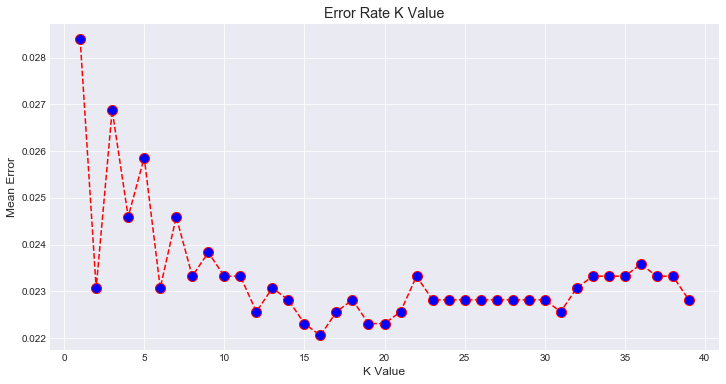

In [385]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')

On peut voir que l'erreur est minimal pour k entre 15 et 20, nous allons donc relancer l'algorithme avec une valeur de k dans cet intervalle.

In [386]:
neigh = KNeighborsClassifier(n_neighbors=16)
neigh.fit(X_train, y) 
y_pred=neigh.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3839
           1       0.59      0.56      0.58       105

   micro avg       0.98      0.98      0.98      3944
   macro avg       0.79      0.78      0.78      3944
weighted avg       0.98      0.98      0.98      3944



On obtient une précision un petit peu plus élevé pour la classe 1, notre modèle semble donc être plus performant avec un k un peu plus élevée.

In [387]:
proba=neigh.predict_proba(X_test)
proba=pd.DataFrame(clf.predict_proba(X_test), columns=clf.classes_)
p=proba.loc[:,1]
nba_test = nba_test.assign(Predictions=y_pred)
nba_test = nba_test.assign(Proba1=p.values)
nba_test

,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle,isAllNBA,Predictions,Proba1
8555,Jeff Adrien,PF,24,2011,GSW,23.0,0.0,8.521739,11.3,-5.1,...,1.000000,1.521739,0.173913,0.217391,0.391304,1.217391,GSW2011Jeff Adrien,0,0,0.000033
8556,Arron Afflalo,SG,25,2011,DEN,69.0,69.0,33.681159,13.6,2.1,...,0.652174,2.985507,0.492754,0.449275,1.028986,2.217391,DEN2011Arron Afflalo,0,0,0.118280
8557,Alexis Ajinca,C,22,2011,TOT,34.0,2.0,10.000000,12.2,-3.4,...,0.500000,1.794118,0.323529,0.558824,0.529412,2.147059,TOT2011Alexis Ajinca,0,0,0.000107
8558,Solomon Alabi,C,22,2011,TOR,12.0,0.0,4.916667,2.0,-8.2,...,0.583333,0.583333,0.166667,0.166667,0.250000,0.416667,TOR2011Solomon Alabi,0,0,0.000033
8559,Cole Aldrich,C,22,2011,OKC,18.0,0.0,7.888889,7.0,-0.8,...,0.722222,1.222222,0.277778,0.388889,0.444444,1.666667,OKC2011Cole Aldrich,0,0,0.000033
8560,LaMarcus Aldridge,PF,25,2011,POR,81.0,81.0,39.641975,21.5,2.4,...,3.432099,5.320988,1.012346,1.160494,1.888889,2.716049,POR2011LaMarcus Aldridge,1,0,0.709866
8561,Malik Allen,PF,32,2011,ORL,18.0,0.0,9.888889,3.3,-3.9,...,0.666667,1.111111,0.055556,0.222222,0.166667,1.666667,ORL2011Malik Allen,0,0,0.000033
8562,Ray Allen,SG,35,2011,BOS,80.0,80.0,36.125000,16.4,3.6,...,0.637500,2.787500,0.962500,0.200000,1.462500,1.837500,BOS2011Ray Allen,0,0,0.351866
8563,Tony Allen,SG,29,2011,MEM,72.0,31.0,20.750000,18.3,3.6,...,0.972222,1.708333,1.791667,0.611111,1.194444,2.236111,MEM2011Tony Allen,0,0,0.213689
8564,Al-Farouq Aminu,SF,20,2011,LAC,81.0,14.0,17.925926,9.6,-3.0,...,0.925926,2.370370,0.728395,0.308642,1.271605,1.493827,LAC2011Al-Farouq Aminu,0,0,0.000186


In [388]:
nba_test2019kNN=nba_test.loc[nba_test['year'] == 2019]
nba_test2019kNN.nlargest(15, columns=['Proba1'])


,Player,Position,age,year,Team,Games,Games_started,Minutes,Efficiency_Rating,BoxPlusMinus,...,OffensiveRebound,DefensiveRebound,Steals,Blocks,Turnover,Fouls,cle,isAllNBA,Predictions,Proba1
12288,LeBron James,PF,34,2019,LAL,34.0,34.0,34.647059,26.3,7.7,...,0.941176,7.382353,1.294118,0.705882,3.411765,1.588235,LAL2019LeBron James,0,1,0.995286
12198,Kevin Durant,PF,30,2019,GSW,50.0,50.0,35.500000,24.8,4.4,...,0.480000,6.740000,0.820000,1.160000,3.300000,1.940000,GSW2019Kevin Durant,0,1,0.992957
12177,Stephen Curry,PG,30,2019,GSW,39.0,39.0,34.230769,26.8,7.5,...,0.717949,4.410256,1.179487,0.358974,2.820513,2.589744,GSW2019Stephen Curry,0,1,0.992453
12224,Paul George,SF,28,2019,OKC,48.0,48.0,35.979167,23.9,5.8,...,1.520833,6.562500,2.312500,0.500000,2.645833,2.750000,OKC2019Paul George,0,1,0.983278
12280,Kyrie Irving,PG,26,2019,BOS,43.0,43.0,32.627907,25.4,7.5,...,1.186047,3.604651,1.720930,0.465116,2.697674,2.279070,BOS2019Kyrie Irving,0,1,0.980256
12179,Anthony Davis,C,25,2019,NOP,41.0,41.0,37.048780,31.0,9.0,...,3.365854,9.926829,1.707317,2.560976,2.000000,2.609756,NOP2019Anthony Davis,0,1,0.975714
12328,Damian Lillard,PG,28,2019,POR,50.0,50.0,35.280000,23.6,4.9,...,0.820000,3.680000,1.060000,0.500000,2.780000,1.780000,POR2019Damian Lillard,0,0,0.972549
12463,Karl-Anthony Towns,C,23,2019,MIN,50.0,50.0,33.220000,25.1,6.7,...,3.420000,8.740000,0.960000,1.900000,2.840000,3.740000,MIN2019Karl-Anthony Towns,0,1,0.970499
12200,Joel Embiid,C,24,2019,PHI,46.0,46.0,33.456522,26.0,3.7,...,2.413043,10.913043,0.565217,1.956522,3.456522,3.326087,PHI2019Joel Embiid,0,1,0.964487
12475,Kemba Walker,PG,28,2019,CHO,49.0,49.0,34.346939,20.8,3.2,...,0.530612,3.775510,1.224490,0.530612,2.571429,1.612245,CHO2019Kemba Walker,0,0,0.952002


In [398]:
df1=pd.DataFrame(nba_test2019kNN.nlargest(15, columns=['Proba1'])['Player'])
df2=pd.DataFrame(test2019LR.nlargest(15, columns=['Proba1'])['Player'])
df3=pd.DataFrame(nba_test2019RF.nlargest(15, columns=['Proba1'])['Player'])

In [413]:
df1=df1.assign(PlayerLR=df2['Player'].values,PlayerRF=df3['Player'].values)

df1.sort_values(['Player', 'PlayerLR','PlayerRF'], ascending=[True, True,True]) #censé trier mais ne comprend pas pourquoi la deuxième colonne ne se trie pas

,Player,PlayerLR,PlayerRF
12179,Anthony Davis,Nikola Jokic,Anthony Davis
12242,Blake Griffin,Damian Lillard,Blake Griffin
12328,Damian Lillard,Stephen Curry,Damian Lillard
12089,Giannis Antetokounmpo,Paul George,Giannis Antetokounmpo
12245,James Harden,Kawhi Leonard,James Harden
12200,Joel Embiid,Russell Westbrook,Joel Embiid
12266,Jrue Holiday,Kyrie Irving,Jrue Holiday
12463,Karl-Anthony Towns,Joel Embiid,Karl-Anthony Towns
12475,Kemba Walker,Blake Griffin,Kemba Walker
12198,Kevin Durant,Anthony Davis,Kevin Durant


Finalement, les trois algorithmes ont l'air de s'accorder à l'exception de Nikola Vucevic à la place de Kemba Walker pour la régression logistique. A part cela, on a pu voir que les méthodes se valent, on préferera tout de même les méthodes de régression logistique et de random forest dans le sens où chacune à sa manière permet de faire des prédictions avec un certain schéma : coefficient ou seuil de décision pour l'arbre. Cela permet alors d'avoir une prédiction "analytique" ce qui est peut être moins le cas du kNN.

En tout les cas, on a toujours un risque que la prédiction soit fausse à cause de données inobservables (ou du moins non modéliser dans notre étude comme la popularité), cependant notre étude a montré que la data science et les méthodes associés peuvent bien jouer un rôle dans la prédiction All NBA et plus largement dans le sport.

# 4. Conclusion

En conclusion, notre but était de savoir si l'on pouvait prédire les teams All NBA à l'aide du Machine Learning. Bien que nos résultats ne soient pas parfaits, on peut voir que malgré tout on arrive à prédire pas mal de sélections All NBA grâce à nos modèles. En ce qui concerne la sélection All NBA 2019 est pour bientôt et nous dira si notre prédiction s'est révélée juste cependant à en croire les analystes notre composition ne semble pas très éloignée de ce qui pourrait se produire même si l'on peut attendre raisonnablement 2-3 surprises. En tout les cas, sur les données test, les modèles se sont révélés assez performants avec quelques erreurs de classification difficile à éviter du notamment à des problèmes de popularité, nationalité, etc...

Nous avons essayé dans cette étude de prendre un maximum de recul sur ce que l'on faisait. Ainsi, notre principale difficulté a été de gérer l'imbalance mais ce fut un exercice très intéressant puisque la majorité des datasets sont distribués ainsi dans la vraie vie. Nous avons tenté de proposer des solutions à cet imbalalance bien que nous supposons qu'il existe de meilleurs traitement que ce que l'on a fait. Les modèles n'ont pas été choisis pour être comparés et optimiser l'erreur, il s'agit de différentes approches qui permettent de mieux comprendre le problème et les déterminants de la sélection.